# Methods for Feature Selection


*Before usage of this notebook, please download folder from this link https://drive.google.com/open?id=1Eme87KqRZx8-sANpoHeCIOOWcSRYsMLy
and store the files in the same folder which is location for this notebook.*    

### Importing the data 

In [2]:
import h5py                                     # Importing the h5 package.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PyDynamic  


C:\Users\jugo01\AppData\Local\Continuum\anaconda3\envs\Zema\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\jugo01\AppData\Local\Continuum\anaconda3\envs\Zema\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [1]:
from PyDynamic import __version__ as version
version


C:\Users\jugo01\AppData\Local\Continuum\anaconda3\envs\Zema\lib\site-packages\PyDynamic\identification\fit_filter.py:34: DeprecationWarning: The module *identification* will be combined with the module *deconvolution* and renamed to *model_estimation* in the next major release 3.0. From then on you should only use the new module *model_estimation* instead.
  DeprecationWarning)


'1.2.79'

In [3]:
filename = 'Sensor_data_2kHz.h5'                # Data filename.
f = h5py.File(filename, 'r')                    # Importing the h5 file. 

#print("Keys: %s" % f.keys())
a_group_key = list(f.keys())[0]

data = list(f[a_group_key])                     # Transforming data into list

sensorADC=[]                                       # Initialising a list "sensor" and
for i in range(11):                                # Filling it with data from all sensors 
    sensorADC.append(pd.DataFrame(data[i][:][:]))

for i in range(11):                             
    sensorADC[i]=sensorADC[i].iloc[:,:6291]           # Cuting the last cycle because it contains all zero elements.

print("""    
    Input matrices have dimensions: %s, where %s represents number of measurements in time
    and %s represents number of cycles.""" % (np.shape(sensorADC[0]),np.shape(sensorADC[0])[0],np.shape(sensorADC[0])[1]))

    
    Input matrices have dimensions: (2000, 6291), where 2000 represents number of measurements in time
    and 6291 represents number of cycles.


### Converting into SI units 

In [4]:
offset=[0, 0, 0, 0, 0.00488591, 0.00488591, 0.00488591,  0.00488591, 1.36e-2, 1.5e-2, 1.09e-2]
gain=[5.36e-9, 5.36e-9, 5.36e-9, 5.36e-9, 3.29e-4, 3.29e-4, 3.29e-4, 3.29e-4, 8.76e-5, 8.68e-5, 8.65e-5]
b=[1, 1, 1, 1, 1, 1, 1, 1, 5.299641744, 5.299641744, 5.299641744]
k=[250, 1, 10, 10, 1.25, 1, 30, 0.5, 2, 2, 2]
units=['[Pa]', '[g]', '[g]', '[g]', '[kN]', '[bar]', '[mm/s]', '[A]', '[A]', '[A]', '[A]']

sensor=[0]*len(sensorADC)

for i in range(len(sensorADC)):
    sensor[i]=((sensorADC[i]*gain[i])+offset[i])*b[i]*k[i]


###### If you have problems with previous step, you can skip conversion into SI units by running next cell.

In [5]:
sensor=sensorADC

### Reading of train and test data
*Note: see 2_Machine_Learning_using_Best_Fourier_Coefficients.ipynb. Data were split into train and test data for k=85% 
Based on this, target_train_vector and target_test_vector were provided. These vectors will be used for FFT and DFT methods.*

In [5]:
import os
import h5py

train_test1= h5py.File("Train_test_data.hdf5","r")


In [6]:
target_train_vector=train_test1["target_train_vector"]
target_test_vector=train_test1["target_test_vector"]


Converting arrays into data frames:

In [7]:
target_train_vector=pd.DataFrame(target_train_vector)
target_test_vector=pd.DataFrame(target_test_vector)

In [9]:
target=list(target_train_vector[0])


So, after this step main data to work on are lists: 

"sensor_train" with their class labels "train_target"
 
and 
 
"sensor_test" with their class labels "test_target"

In [10]:
sensor_train=[0]*11
sensor_test=[0]*11

for i in range(11):
    sensor_train[i]=sensor[i].loc[:,target_train_vector.index]

print("Traning data for one sensor has dimensions: ", sensor_train[10].shape,",      ('sensor_train') ")
print("and it's target vector has length: ", target_train_vector.shape,",               ('target_train_vector') \n")

for i in range(11):
    sensor_test[i]=sensor[i].loc[:,target_test_vector.index]

print("Testing data for one sensor has dimensions: ", sensor_test[10].shape,",      ('sensor_test') ")
print("and it's target vector has length: ", target_test_vector.shape,",        ('target_test_vector') \n")

Traning data for one sensor has dimensions:  (2000, 5347) ,      ('sensor_train') 
and it's target vector has length:  (5347, 1) ,               ('target_train_vector') 

Testing data for one sensor has dimensions:  (2000, 944) ,      ('sensor_test') 
and it's target vector has length:  (944, 1) ,        ('target_test_vector') 



We can have a look at the data from one sensor after splitting for better understanding of structure for next steps. Number of rows is 2000 and each column is one random measurement cycle. Table shows only first five samples in time (five rows) for each cycle. 

In [10]:
sensor_train[0].head()

0         1         2         3         4         5         6     \
0 -0.052346  0.035353  0.150057  0.165182  0.007607  0.085452 -0.004497   
1  0.013661  0.062294  0.073791  0.002720  0.045830  0.097229  0.054530   
2  0.088680 -0.157930  0.016507  0.020354  0.090973 -0.215526  0.061279   
3  0.040834 -0.081864  0.264404  0.090820  0.189913  0.068431 -0.101957   
4  0.033578 -0.044107  0.056629  0.022157  0.091190 -0.215849 -0.147002   

       7         8         9     ...      5337      5338      5339      5340  \
0 -0.015737  0.004307  0.030425  ... -0.175565  0.329240  0.210907  0.184818   
1  0.065786  0.283926  0.108324  ... -0.218415  0.447456  0.349365  0.299143   
2  0.034248  0.184389  0.141985  ... -0.369747  0.213356  0.078377  0.058016   
3  0.105077  0.037419  0.232769  ...  0.012711  0.306476  0.201671  0.298681   
4  0.120792  0.155922  0.038234  ... -0.026665  0.382832  0.299239  0.259937   

       5341      5342      5343      5344      5345      5346  
0  0.050059  0.108024  0.142261  0.358908  0.161659  0.362495  
1  0.048282  0.207124  0.431144  0.638964  0.378436  0.698642  
2 -0.075154  0.073886  0.393118  0.545816  0.170193  0.216192  
3  0.069645  0.011811  0.371483  0.673113  0.286716  0.490413  
4  0.135226  0.151655  0.500641  0.763004  0.247051  0.542166  

[5 rows x 5347 columns]

## Feature selection 
### 1) Feature selection using Pearson correlation coefficients

After all these unsupervised steps, this step is done with knowledge of cycle‚Äòs group affiliation. Selection is based on a target vector which represents label for each cycle. The method is very simple, Pearson correlation coefficient is calculated between selected features and target vector and it is done for all sensors. After that, number of features with overall highest Pearson correlation coefficients is selected.

#### Pearson correlation

A Pearson correlation is a number between -1 and 1 that indicates the extent to which two variables are linearly related. A correlation coefficient indicates the extent to which dots in a scatterplot lie on a straight line. The stronger the association of the two variables, the closer the Pearson correlation coefficient, r, will be to either +1 or -1 depending on whether the relationship is positive or negative, respectively.

_Pearson correlation formula [3]:_

<img src="pictures/formula1.png">

- $x$ and $y$ are two vectors of length n
- $m_x$ and $m_y$ corresponds to the means of x and y, respectively.

Different relationships and their correlation coefficients are shown in the figure below [4]:

<img src="pictures/Correlation_examples.png">

Firstly, correlation coefficients are calculated for all features and their values are stored in the list `corr`. Then, function called `largest_indices` finds indices for wanted amount of features with highest correlation coefficients. Function output is stored into lists 'sensor_n' and 'feature_n', where element in 'sensor_n' means which sensor, and related element in 'feature_n' means which feature of that sensor is accessed.

Example:
If element in 'sensor_n' is 5, and the element in 'feature_n' at the same position is 50, that means that you can access that feature in this way:

``` python
    sorted_values_from_all_sensors[5].iloc[:][50]
```


*Reading the data for 10% of the highest amplitudes from the file Machine_Learning_using_Best_Fourier_Coefficients.ipynb calculated from FFT:
Values were obtained by using factor of splitting data into train and test from the above.*

In [12]:
import os
import h5py

amp_fft1= h5py.File("Sorted_vaules_from_all_sensors.hdf5","r")
freq_fft1= h5py.File("Sorted_freq_from_all_sensors.hdf5","r")    



In [13]:
freq_of_sorted_values=[0]*len(sensor_train)
sorted_values_from_all_sensors=[0]*len(sensor_train)
for i in range(len(sensor)):
    freq_of_sorted_values[i]=freq_fft1["freq_of_sorted_values"+str(i)]
    sorted_values_from_all_sensors[i]=amp_fft1["sorted_values_from_all_sensors"+str(i)]

    

Results provided from FFT do not contain uncertainties. First method analyzed for the feature selection is Pearson correlation performed on these data.

In [14]:
from scipy.stats import pearsonr
def Pearson_corr(sorted_values,N,n_of_samples):
    corr=[None]*(len(sorted_values))                     # Making list for correlation coefficients.
    p_value=[None]*(len(sorted_values))

    for j in range(len(sorted_values)):                       # Making sublists in "corr" for each sensor.
        corr[j]=[None]*((round((N/100.0)*n_of_samples/2)))
        p_value[j]=[None]*((round((N/100.0)*n_of_samples/2)))
    
    # Calculating correlation coefficients for each column of each sensor with respect to target.
    for j in range(11):
        for i in range(round((N/100.0)*n_of_samples/2)):
            corr[j][i],p_value[j][i]=pearsonr(np.abs(sorted_values[j][:,i]),target_train_vector[0])

    #matrix_corr_coeff = np.transpose(pd.DataFrame(corr))# Transforming list of correlation coefficients to data frame.
    corr_array=np.array(corr)                                   # Transforming list of correlation coefficients to nparray

    
    return corr_array

In [15]:
def largest_indices(array, n):                               # Function that find indices for 500 biggest Pearson-
    """Returns the n largest indices from a numpy array."""  # -correlation coefficients.
    flat = array.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, array.shape)  


#### Function execution

In [16]:
N=10 #percentage of highest amplitudes, see: Machine_Learning_using_Best_Fourier_Coefficients.ipynb
n_of_samples=2000 #number of samples, see: Machine_Learning_using_Best_Fourier_Coefficients.ipynb

n_features_for_select=0
for i in range(len(sorted_values_from_all_sensors)):
    n_features_for_select=n_features_for_select+int(len(sorted_values_from_all_sensors[i][0,:]))

# Defining how much of features with biggest Pearson correllation coeff. will be selected.
n_of_features = int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select))


target_matrix = pd.DataFrame(target)        # Transforming list "target" into data frame "target_matrix"

print("\nDimension of target matrix is:")
print("                                                 ", target_train_vector.shape)
print("Dimension of amplitude matrix for one sensor is:")
print("                                                 ", sorted_values_from_all_sensors[0][:,:].shape)

corr_array_p=Pearson_corr(sorted_values_from_all_sensors,N,n_of_samples)
print("Array of correlation coefficients has size:")
print("                                                 ",corr_array_p.shape)  
# sensor_n is the index of the sensor number.
# feature_n is the index of the feature number for each sensor number.
sensor_n, feature_n = largest_indices(corr_array_p, n_of_features)

print("Sensor indices of location of features in >sorted_values_from_all_sensors< matrix: \n")
print(sensor_n)
print("\nColumn indices of location of features in >sorted_values_from_all_sensors< matrix: \n")
print(feature_n)

How many features out of 1100 you want to select (recommended is 500): 500

Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients has size:
                                                  (11, 100)
Sensor indices of location of features in >sorted_values_from_all_sensors< matrix: 

[ 7 10 10  8  8  2  9  0  0  1  0  7  2  3  9  2  2  3  5  1  3  3  7  9
  3  3  3 10  7  0  5  2  0  0  0  0  0  0  3  9  2  2  3  7  3  3  3  3
  3  0  3  0  3  3  3  3  0  2  0  3  3  2  9  2  0  3  3  2  2  7  0  0
  2  3  2  2  0  8 10  2  2  3  3  3  2  0  8  3  3  2  0  3  1  3  2  0
  3  1  2  3  3  9  3  3  0  8  0  3 10  3  3  2  1  0 10  3  7  3  0  2
  0  3 10  3  0  0  3  9  3  2  7  3  2  9  3  9 10  1 10  1  7  3  5  0
  7  2  2  8  1  7 10  2  2  2  1  8  2  2  9  3  2 10  0  2  2  0  2  2
  0  0  0 10  2  2  2 

Based on the found indices for highest features, all of them are put together into a list `top_n_features`, but separated into sublists based on the sensor they are taken from. Then, by comparing the sizes of these groups it is shown how many of those selected features are from which sensor.

After that, they are merged into one feature matrix `abs_top_n_together_matrix`, and all steps from here on are done on these features with absolute values.

In [17]:
def percentage (sensor_ind,feature_ind,sorted_values_from_all_sensors):
    # Initialising a list of best features. 11 sublists containing features from each sensor, respectively.
    top_n_features=[[], [], [], [], [], [], [], [], [], [], []]
    for i in range(len(sorted_values_from_all_sensors)):
        for j in range(len(sensor_ind)):
            if sensor_ind[j]==i:
                top_n_features[i].append(sorted_values_from_all_sensors[i][:,feature_ind[j]]);

    for i in range(len(sorted_values_from_all_sensors)):
        for j in range(len(top_n_features[i])):
            top_n_features[i][j]=list(top_n_features[i][j])

    # Merging sublists into one list with all elements.
    top_n_together=[j for i in top_n_features for j in i]  

    top_n_together_matrix=np.transpose(pd.DataFrame(top_n_together))
    print(type(top_n_together_matrix), "\n")

    # Continue working with abosulte values.
    abs_top_n_together_matrix=np.abs(top_n_together_matrix)

    percentage=[None]*(len(sorted_values_from_all_sensors))
    k=0
    for i in range(len(sorted_values_from_all_sensors)):
        #print(top_n_features_matrix.shape)
        print("Number of features from sensor %2.0f is: %3.0f or  %4.2f %%" % (i, len(top_n_features[i]), len(top_n_features[i])/len(sensor_ind)*100))
        percentage[i]=len(top_n_features[i])
        k=k+len(top_n_features[i])/len(sensor_ind)*100
    print("----------------------------------------------------")
    print("                                             %4.2f" % (k))

    return percentage,abs_top_n_together_matrix

In [18]:

abs_top_n_together_matrix=np.zeros((sorted_values_from_all_sensors[0].shape[0], n_features_for_select))
percentage_p,abs_top_n_together_matrix=percentage(sensor_n,feature_n,sorted_values_from_all_sensors)

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  74 or  14.80 %
Number of features from sensor  1 is:  38 or  7.60 %
Number of features from sensor  2 is:  79 or  15.80 %
Number of features from sensor  3 is:  77 or  15.40 %
Number of features from sensor  4 is:   7 or  1.40 %
Number of features from sensor  5 is:   6 or  1.20 %
Number of features from sensor  6 is:   5 or  1.00 %
Number of features from sensor  7 is:  71 or  14.20 %
Number of features from sensor  8 is:  51 or  10.20 %
Number of features from sensor  9 is:  45 or  9.00 %
Number of features from sensor 10 is:  47 or  9.40 %
----------------------------------------------------
                                             100.00


In [11]:
import os
import h5py

amp_dft2= h5py.File("DFTSorted_vaules__from_all_sensors.hdf5","r")
freq_dft2= h5py.File("DFTSorted_freq_from_all_sensors.hdf5","r") 
ph_dft2= h5py.File("DFTSorted_ph_from_all_sensors.hdf5","r")
u_a_dft2= h5py.File("DFTSorted_uncer_from_all_sensors_a.hdf5","r")
u_ap_dft2= h5py.File("DFTSorted_uncer_from_all_sensors_ap.hdf5","r")    
u_pp_dft= h5py.File("DFTSorted_uncer_from_all_sensors_pp.hdf5","r")    


In [12]:
freq_of_sorted_values=[0]*len(sensor_train)
sorted_values__amp_from_all_sensors=[0]*len(sensor_train)
sorted_uncer_from_all_sensors_a=[0]*len(sensor_train)
for i in range(len(sensor)):
    freq_of_sorted_values[i]=freq_dft2["freq_of_sorted_values"+str(i)]
    sorted_values__amp_from_all_sensors[i]=amp_dft2["sorted_values_amp_from_all_sensors"+str(i)]
    sorted_uncer_from_all_sensors_a[i]=u_a_dft2["sorted_uncer_from_all_sensors_a"+str(i)]
    

###  2) Weighted correlation

A weighted correlation allows application of a weight, or relative significance to each value comparison. Correlation comparisons with a higher value for their weight are considered as more significant when compared to the other value comparisons. Weighted correlation requires following arguments:

- x and y are - values being compared.
- w is the weight applied to each comparison. With these arguments, it is possible to calculate:

weighted mean:
$$m(x;w)=\frac {\sum_{i}w_i*x_i}{\sum_{i}w_i}$$ 
weighted covariance:
$$cov(x,y;w)=\frac {\sum _{i}w_i(x_i-m(x;w))(y_i-m(y;w))}{\sum _{i}w_i} $$
weighted correlation:
$$corr(x,y;w)=\frac{cov(x,y;w)}{\sqrt{cov(x,x;w)*cov(y,y;w))}}$$

Correlation is weighted with weight factor:
$$ w_i= \frac {1}{u¬≤({x_i})}$$
where $x_{i}$ represents amplitudes and $u¬≤(x_{i})$ their standard squared uncertainties.

In [22]:
#Calculating weights from diagonal elements of uncertainty matrix
# W -list of eleven np.arrays sized (number of cycles, N% of amplitudes) containing weight factors
W=[None]*len(sorted_values__amp_from_all_sensors)
B=np.zeros((sorted_values__amp_from_all_sensors[0].shape))
for k in range(len(sorted_values__amp_from_all_sensors)):
    for i in range (sorted_values__amp_from_all_sensors[0].shape[0]):
        B[i]=1/((sorted_uncer_from_all_sensors_a[k][i,:])) #elements in u_a already squared
    W[k]=B

In [23]:
#weighted mean
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)
#weighted covariance
def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)
#weighted correlation
def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

Implementing functions m, cov and corr for the largest correlation coefficients:

In [24]:
n_features_for_select_w=0
for i in range(len(sorted_values__amp_from_all_sensors)):
    n_features_for_select_w=n_features_for_select_w+int(len(sorted_values__amp_from_all_sensors[i][0,:]))

# Defining how much of features with biggest correllation coeff. will be selected.
n_of_features_w = int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select_w))


target_matrix = pd.DataFrame(target)        # Transforming list "target" into data frame "target_matrix"

print("\nDimension of target matrix is:")
print("                                                 ", target_train_vector.shape)
print("Dimension of amplitude matrix for one sensor is:")
print("                                                 ", sorted_values__amp_from_all_sensors[0][:,:].shape)

weighted_mean=[None]*len(sorted_values__amp_from_all_sensors)                      # Making list for weighted mean, covariance andf correlation coefficients.
weighted_covariance=[None]*len(sorted_values__amp_from_all_sensors) 
weighted_corelation=[None]*len(sorted_values__amp_from_all_sensors) 
for j in range(len(sorted_values__amp_from_all_sensors)):                       # Making sublists " for each sensor.
    
    weighted_mean[j]=[None]*(round((N/100.0)*n_of_samples/2))
    weighted_covariance[j]=[None]*(round((N/100.0)*n_of_samples/2))
    weighted_corelation[j]=[None]*(round((N/100.0)*n_of_samples/2))
# Calculating weighted correlation coefficients for each column of each sensor with respect to target.
for j in range(11):
    for i in range(round((N/100.0)*n_of_samples/2)):
        weighted_mean[j][i]=m(sorted_values__amp_from_all_sensors[j][:,i],W[j][:,i])
        weighted_covariance[j][i]=cov(sorted_values__amp_from_all_sensors[j][:,i],target_train_vector[0],W[j][:,i])
        weighted_corelation[j][i]=corr(sorted_values__amp_from_all_sensors[j][:,i],target_train_vector[0],W[j][:,i])
    

corr_array_w=np.array(weighted_corelation) # Transforming list of correlation coefficients to nparray

print("Array of weighted correlation coefficients has size:")
print("                                                 ",corr_array_w.shape)  

sensor_n_w, feature_n_w = largest_indices(corr_array_w, n_of_features)

print("Sensor indices of location of features in >sorted_values__amp_from_all_sensors< matrix: \n")
print(sensor_n_w)
print("\nColumn indices of location of features in >sorted_values__amp_from_all_sensors< matrix: \n")
print(feature_n_w)

How many features out of 1100 you want to select (recommended is 500): 500

Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of weighted correlation coefficients has size:
                                                  (11, 100)
Sensor indices of location of features in >sorted_values__amp_from_all_sensors< matrix: 

[ 7 10 10  8  8  2  9  0  0  1  0  7  2  3  9  2  2  3  5  1  3  3  7  9
  3  3  3 10  7  0  5  2  0  0  0  0  0  0  3  9  2  2  3  7  3  3  3  3
  3  0  3  0  3  3  3  3  0  2  0  3  3  2  9  2  0  3  3  2  2  7  0  0
  2  3  2  2  0  8 10  2  2  3  3  3  2  0  8  3  3  2  0  3  1  3  2  0
  3  1  2  3  3  9  3  3  0  8  0  3 10  3  3  2  1  0 10  3  7  3  0  2
  0  3 10  3  0  0  3  9  3  2  7  3  2  9  3  9 10  1 10  1  7  3  5  0
  7  2  2  8  1  7 10  2  2  2  1  8  2  2  9  3  2 10  0  2  2  0  2  2
  0  0  

Representation of sensors in percentages for each tral has been given  in the list percentage_w:

In [25]:
abs_top_n_together_matrix_w=np.zeros((sorted_values__amp_from_all_sensors[0].shape[0],n_features_for_select))
percentage_w,abs_top_n_together_matrix_w=percentage(sensor_n_w,feature_n_w,sorted_values__amp_from_all_sensors)

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  74 or  14.80 %
Number of features from sensor  1 is:  38 or  7.60 %
Number of features from sensor  2 is:  79 or  15.80 %
Number of features from sensor  3 is:  77 or  15.40 %
Number of features from sensor  4 is:   7 or  1.40 %
Number of features from sensor  5 is:   6 or  1.20 %
Number of features from sensor  6 is:   5 or  1.00 %
Number of features from sensor  7 is:  71 or  14.20 %
Number of features from sensor  8 is:  51 or  10.20 %
Number of features from sensor  9 is:  45 or  9.00 %
Number of features from sensor 10 is:  47 or  9.40 %
----------------------------------------------------
                                             100.00


The plot shows comparison of frequency of occurrences for the features with highest correlation coefficients in case of methods: Weighted correlation and Pearson correlation (for N% of amplitudes only). It is visible that for this case, both methods provide the same results. Uncertainties considered as weights do not have impact on selection of the features.

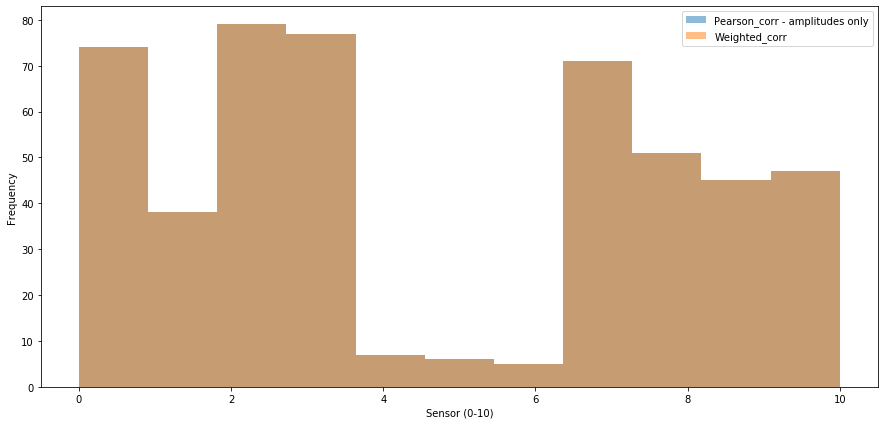

In [26]:

bins = len(sensor)
plt.figure(figsize=(15,7))
plt.hist(sensor_n, bins, alpha=0.5, label='Pearson_corr - amplitudes only')
plt.xlabel("Sensor (0-10)")
plt.ylabel("Frequency") 
plt.hist(sensor_n_w, bins, alpha=0.5, label='Weighted_corr')
plt.legend(loc='upper right')
plt.show()

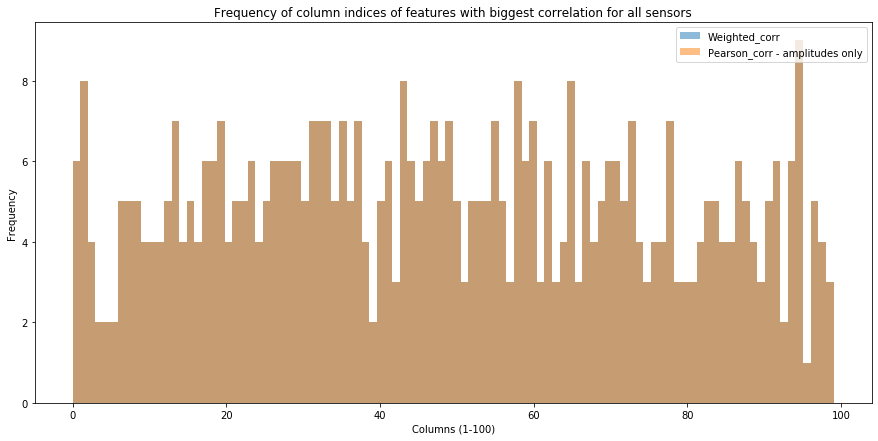

In [27]:

    bins = sorted_values__amp_from_all_sensors[0].shape[1]
    plt.figure(figsize=(15,7))
    plt.hist(feature_n_w, bins, alpha=0.5, label='Weighted_corr')
    plt.hist(feature_n, bins, alpha=0.5, label='Pearson_corr - amplitudes only')
    plt.xlabel("Columns (1-100)")
    plt.ylabel("Frequency")
    plt.title("Frequency of column indices of features with biggest correlation for all sensors")
    plt.legend(loc='upper right')
    plt.show()



### 3) Monte Carlo method for the feature selection

*Reading the data for 10% of the highest amplitudes from the file Machine_Learning_using_Best_Fourier_Coefficients.ipynb calculated from DFT:
Values were obtained by using factor of splitting data into train and test from the above.*

In [28]:
import os
import h5py

amp_dft2= h5py.File("DFTSorted_vaules__from_all_sensors.hdf5","r")
freq_dft2= h5py.File("DFTSorted_freq_from_all_sensors.hdf5","r") 
ph_dft2= h5py.File("DFTSorted_ph_from_all_sensors.hdf5","r")
u_a_dft2= h5py.File("DFTSorted_uncer_from_all_sensors_a.hdf5","r")
u_ap_dft2= h5py.File("DFTSorted_uncer_from_all_sensors_ap.hdf5","r")    
u_pp_dft= h5py.File("DFTSorted_uncer_from_all_sensors_pp.hdf5","r")    


In [29]:
freq_of_sorted_values=[None]*len(sensor_train)
sorted_values__amp_from_all_sensors=[None]*len(sensor_train)
sorted_uncer_from_all_sensors_a=[None]*len(sensor_train)
for i in range(len(sensor)):
    freq_of_sorted_values[i]=freq_dft2["freq_of_sorted_values"+str(i)]
    sorted_values__amp_from_all_sensors[i]=amp_dft2["sorted_values_amp_from_all_sensors"+str(i)]
    sorted_uncer_from_all_sensors_a[i]=u_a_dft2["sorted_uncer_from_all_sensors_a"+str(i)]
    

Results provided from DFT contain uncertainties of amplitudes, phases and their covariances. Third method analyzed for the feature selection is Monte Carlo method which uses Pearson correlation performed on these data. 

Random samples were taken from multivariate normal distribution with amplitudes as means and their uncertainties as standard deviations. Phases and their uncertainties have not been included. These samples have been propagated through the model function. Features have been selected based on the outcomes of Monte Carlo method.


Monte Carlo method provides:

1) best estimate
\begin{align}
\mathbf{y} =& mean \{ \mathbf{y}^{(k)}, k=1,\ldots,M\} \\
=& \frac{1}{M} \sum_{k=1}^M \mathbf{y}^{(k)}
\end{align}
2) uncertainty associated with the best estimate
\begin{align}
U_\mathbf{y} =& cov\{ \mathbf{y}^{(k)}, k=1,\ldots,M\} \\
=& \frac{1}{M-1} \sum_{k=1}^M (\mathbf{y}^{(k)}-\mathbf{y})^T(\mathbf{y}^{(k)}-\mathbf{y})
\end{align}



The application of Monte Carlo method can be stated through following steps:

1) Class `Normal_ZeroCorr` -  Multivariate normal distribution with zero correlation was defined. 


In [30]:
# Source code from PyDynamic
class Normal_ZeroCorr:
    """     Multivariate normal distribution with zero correlation"""
    def __init__(self, loc=np.zeros(1), scale=np.zeros(1)):
        """
        Parameters
        ----------
            loc: np.ndarray, optional
                mean values, default is zero
            scale: np.ndarray, optional
                standard deviations for the elements in loc, default is zero
        """
        if isinstance(loc, np.ndarray) or isinstance(scale, np.ndarray):
            # convert loc to array if necessary
            if not isinstance(loc, np.ndarray):
                self.loc = loc * np.ones(1)
            else:
                self.loc = loc
            # convert scale to arraym if necessary
            if not isinstance(scale, np.ndarray):
                self.scale = scale * np.ones(1)
            else:
                self.scale = scale

            # if one of both (loc/scale) has length one, make it bigger to fit
            # size of the other
            if self.loc.size != self.scale.size:
                Nmax = max(self.loc.size, self.scale.size)
                if self.loc.size == 1 and self.scale.size != 1:
                    self.loc = self.loc * np.ones(Nmax)
                elif self.scale.size == 1 and self.loc.size != 1:
                    self.scale = self.scale * np.ones(Nmax)
                else:
                    raise ValueError(
                        "loc and scale do not have the same dimensions. (And "
                        "none of them has dim == 1)")
        else:
            raise TypeError("At least one of loc or scale must be of type "
                            "numpy.ndarray.")
    def rvs(self, size=1):
        # This function mimics the behavior of the scipy stats package
        return np.tile(self.loc, (size, 1)) + \
               np.random.randn(size, len(self.loc)) * \
               np.tile(self.scale, (size, 1))

2) N% of amplitudes are considered as input quantities *Xi*, along with their uncertainties. 

3) Sampling from the assigned distribution (in this case, normal distribution ) is performed  for every cycle by using class `Normal_ZeroCorr` -  Multivariate normal distribution with zero correlation, because only information about amplitudes are the means and standard uncertainties. For example, number of  draws is 100.

4) List *Xi_dist* contains 100 samples from multivariate normal distribution of N% of amplitudes for each cycle.  One cycle, 100 sampless for 100 (10%) amplitudes. 

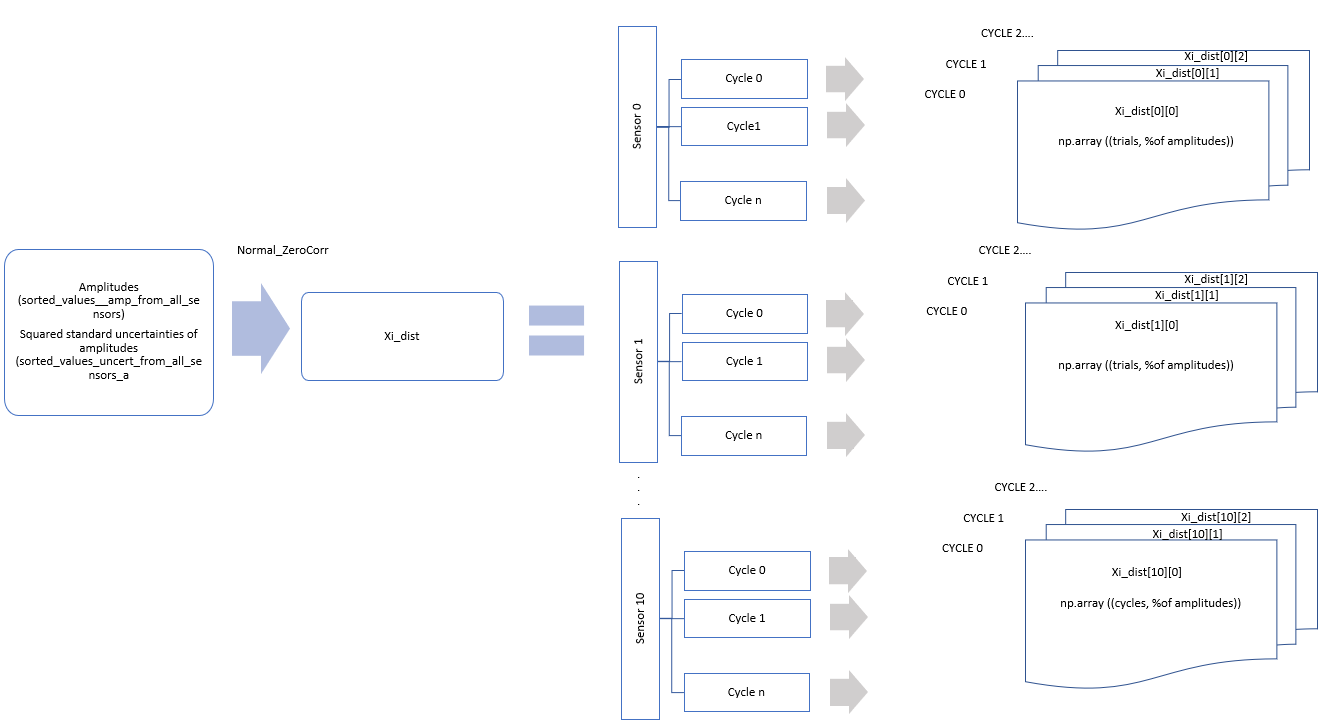
5) List *A* collects samples from all cycles for each trial. This means, for example for the first trial, first samples from all cycles were collected.
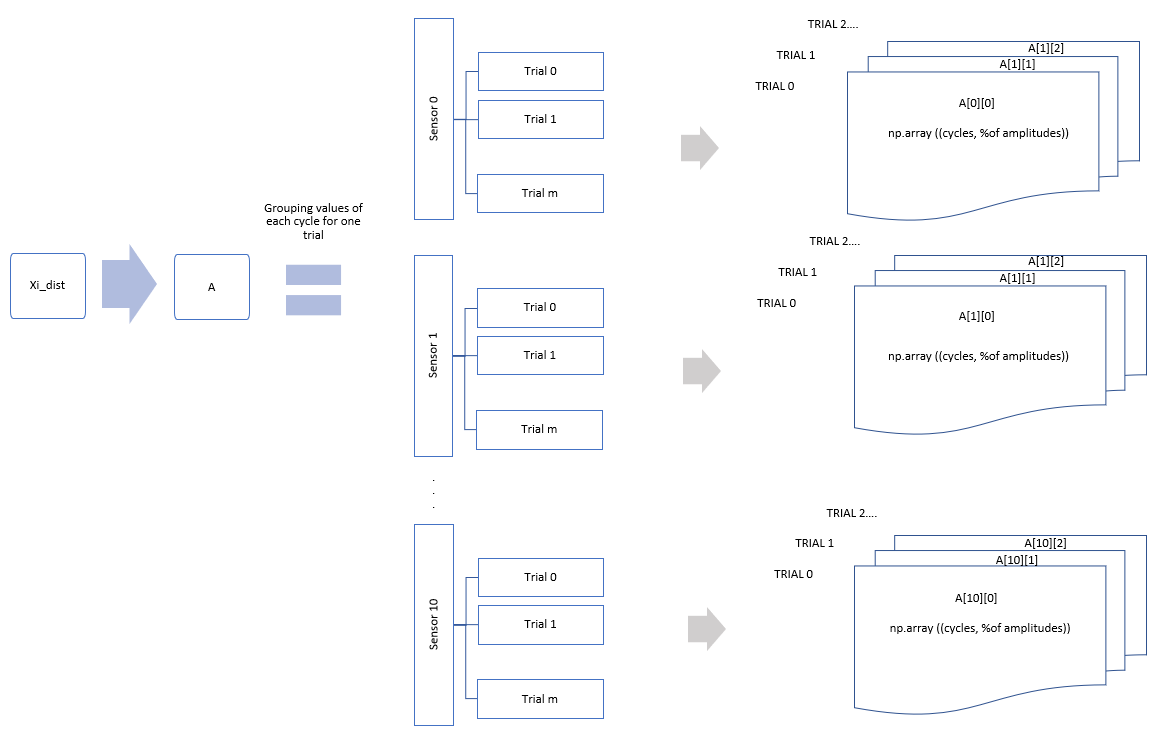
*Note: Despite the mathematical and physical connection of amplitude and phase, in many practical cases the covariances  are considered to be zero.*



In [31]:
#setting draws
def group_draws(draws,sorted_amplitudes,sorted_uncer):
    
#Xi_dist collects samples in draws for every sensor
    Xi_dist=[None]*(len(sorted_amplitudes))
    for s in range(len(sorted_amplitudes)):
    #Example: sensor index=0, 5000 cycles, 1000 draws for each cycle,N% of amplitudes = 100: 
    #Xi_dist[0][:5000].shape=(1000,100)
        Xi_dist[s]=[None]*(sorted_amplitudes[0].shape[0])
        for d in range(sorted_amplitudes[0].shape[0]):
            Xi_dist[s][d]=np.zeros((draws,sorted_amplitudes[0].shape[1]))
#A - collecting value of each trial for every cycle. 
    A=[None]*(draws)

    for f in range(draws):
#Example: Zero sensor, first draw, - A[0][1].shape=5347,100
#initializing zero values
        A[f]=[None]*(len(sorted_amplitudes))
        for s in range(len(sorted_amplitudes)):
        #Example:sensor index=0, 5000 cycles, 1000 draws for each cycle,N% of amplitudes = 100: 
        #A[:1000][0].shape=(5000,100)
            A[f][s]=np.zeros((sorted_amplitudes[0].shape))

    for i in range(len(sorted_amplitudes)):
        for m in range(sorted_amplitudes[0].shape[0]):
            dist = Normal_ZeroCorr(loc=sorted_amplitudes[i][m,:],scale=np.sqrt(sorted_uncer[i][m,:]))
            Xi_dist[i][m]=dist.rvs(draws)
        #A matrix will be used for Pearson's correlation:
        # Adding values from Xi_dist to A:
        for j in range(draws):
            for s in range(sorted_amplitudes[0].shape[0]):
                A[j][i][s]=Xi_dist[i][s][j]
    return A

5) Model function is function `largest_indices(corr_array_MC, n_of_features)`, which is based on Pearson correlation.

6) First, Pearson correlation is conducted for *100* MC trials , resulting in:
    
    corr_array_MC=list(range(100))                   
    p_value=list(range(100))

7)  best estimate (mean value) is calculated for trials in every run:
\begin{align}
\mathbf{y}=& mean \{ \mathbf{y}^{(k)}, k=1,\ldots,M\} \\
=& \frac{1}{M} \sum_{k=1}^M \mathbf{y}^{(k)}
\end{align}
8) uncertainty associated with the best estimate
\begin{align}
U_\mathbf{y} =& cov\{ \mathbf{y}^{(k)}, k=1,\ldots,M\} \\
=& \frac{1}{M-1} \sum_{k=1}^M (\mathbf{y}^{(k)}-\mathbf{y})^T(\mathbf{y}^{(k)}-\mathbf{y})
\end{align}

9) Function largest_indices(corr_array n_of_features_x) is executed for every trial.

10) Results of the function execution (sensor and column indices of features) were stored in  lists: 
    sensor_n_x[trial],feature_n_x[trial]. For 100 MC trials, there will be 100 elements of lists in sensor_n_x and feature_n_x containing arrays.
    
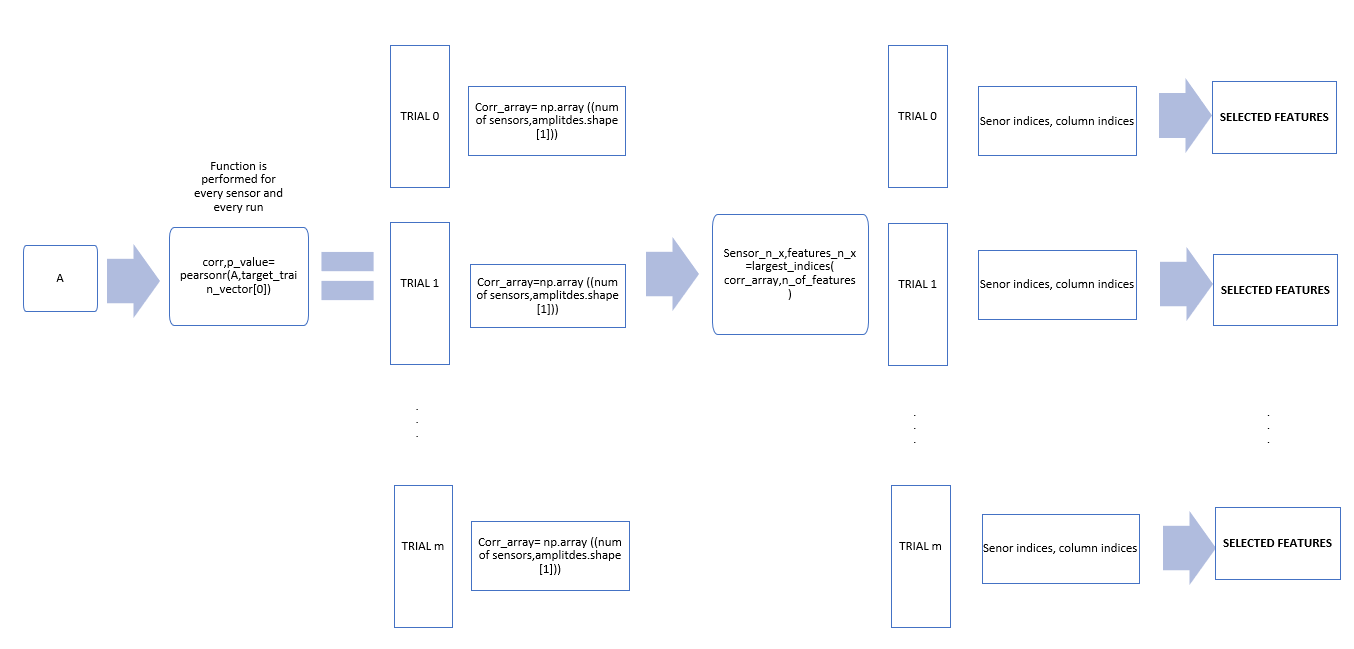


Based on drawn samples, function `Perform_MC` obtains sensor and column indices.

In [32]:
def Perform_MC(samples,N,n_of_samples,n_of_features_x):   
    
    target_matrix = pd.DataFrame(target)        # Transforming list "target" into data frame "target_matrix"
    print("\nDimension of target matrix is:")
    print("                                                 ", target_train_vector.shape)
    print("Dimension of amplitude matrix for one sensor is:")
    print("                                                 ", sorted_values_from_all_sensors[0][:,:].shape)
    corr_array_MC=[None]*(len(samples))
    for s in range(len(samples)):
        corr_array_MC[s]=Pearson_corr(samples[s],N,n_of_samples)
                                            
    corr_array=[None]*(len(samples)) # Transforming list of correlation coefficients to nparray
    for p in range(len(samples)):
        corr_array[p]=np.array(corr_array_MC[p])   
        
    #mean value - best estimate

    corr_array_mean=np.mean(corr_array_MC,axis=0) 
    sum2=0
    for s in range(len(samples)):
        sum2=sum2+np.matmul((corr_array_MC[s]-corr_array_mean).T,(corr_array_MC[s]-corr_array_mean))
    Uy=(1/(len(samples)-1))*sum2

    # Transforming list of correlation coefficients to nparray

    print("Array of correlation coefficients for one trial has size:",corr_array[0].shape)
      
    print("Mean array of correlation coefficients for one trial has size:",corr_array_mean.shape)  
    print("Covariance matrix of correlation coefficients for one trial has size:",Uy.shape)  

    # sensor_n_x is the index of the sensor number.
    # feature_n_x is the index of the feature number for each sensor number.

    sensor_n_x=[None]*(len(samples))
    feature_n_x=[None]*(len(samples))
    for p in range(len(samples)): 
        sensor_n_x[p], feature_n_x[p] = largest_indices(corr_array[p], n_of_features_x)

    print("Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  \n")
    print(sensor_n_x[0])
    print("\nColumn indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix \n")
    print(feature_n_x[0])

    return corr_array,sensor_n_x,feature_n_x,corr_array_mean,Uy

###### Function execution

In [33]:
trials=int(input("Enter the number of MC trials:"))
A=group_draws(trials,sorted_values__amp_from_all_sensors,sorted_uncer_from_all_sensors_a)

Enter the number of MC trials:100


In [34]:

N=10 #percentage of highest amplitudes, see: Machine_Learning_using_Best_Fourier_Coefficients.ipynb
n_of_samples=2000 #number of samples, see: Machine_Learning_using_Best_Fourier_Coefficients.ipynb

n_features_for_select_x=0
for i in range(len(sorted_values__amp_from_all_sensors)):
    n_features_for_select_x=n_features_for_select_x+int(len(sorted_values__amp_from_all_sensors[i][0,:]))

# Defining how much of features with biggest Pearson correllation coeff. will be selected.
n_of_features_x = int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select_x))



corr_array_MC,sensor_n_x,feature_n_x,corr_array_mean,Uy_mean=Perform_MC(A,N,n_of_samples,n_of_features_x)


How many features out of 1100 you want to select (recommended is 500): 500

Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  9  2  3  9  3  3  3  3  2 10  2  2  3  0  7  3  1
  3  0  3  0  3  8  0  1  0  7  8  0  0  0  2  0  3  2  3  2  3  2  3  0
  2 10  2  0  2  3  2  2  0  3  2  3  0  3  3  9  0 10  0  2  3  3  3  2
  0  3  2  8  3  2  3  0  3  3  3  0  3  2  3  3  3  2  3  3  3  0  3  3
  0  3  0  2  2  3  3  0  3  0  0 10 10  3  5  3  2  2  2  2  2  2  2  9
  3  2  2  2  5  2  2 10 

Representation of sensors in percentages for each trial has been given  in the list percentage_x:

In [44]:

abs_top_n_together_matrix_x=[None]*(trials)
percentage_x=[None]*(trials)
for i in range(trials):
     percentage_x[i],abs_top_n_together_matrix_x[i]=percentage(sensor_n_x[i],feature_n_x[i],sorted_values__amp_from_all_sensors)

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  81 or  16.20 %
Number of features from sensor  1 is:  46 or  9.20 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of features from sensor  4 is:  11 or  2.20 %
Number of features from sensor  5 is:   8 or  1.60 %
Number of features from sensor  6 is:   8 or  1.60 %
Number of features from sensor  7 is:  40 or  8.00 %
Number of features from sensor  8 is:  46 or  9.20 %
Number of features from sensor  9 is:  50 or  10.00 %
Number of features from sensor 10 is:  48 or  9.60 %
----------------------------------------------------
                                             100.00
<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  81 or  16.20 %
Number of features from sensor  1 is:  42 or  8.40 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of fea

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  81 or  16.20 %
Number of features from sensor  1 is:  45 or  9.00 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of features from sensor  4 is:  10 or  2.00 %
Number of features from sensor  5 is:   7 or  1.40 %
Number of features from sensor  6 is:   9 or  1.80 %
Number of features from sensor  7 is:  40 or  8.00 %
Number of features from sensor  8 is:  48 or  9.60 %
Number of features from sensor  9 is:  49 or  9.80 %
Number of features from sensor 10 is:  49 or  9.80 %
----------------------------------------------------
                                             100.00
<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  81 or  16.20 %
Number of features from sensor  1 is:  43 or  8.60 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  79 or  15.80 %
Number of feat

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  81 or  16.20 %
Number of features from sensor  1 is:  43 or  8.60 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of features from sensor  4 is:  13 or  2.60 %
Number of features from sensor  5 is:   7 or  1.40 %
Number of features from sensor  6 is:   6 or  1.20 %
Number of features from sensor  7 is:  42 or  8.40 %
Number of features from sensor  8 is:  45 or  9.00 %
Number of features from sensor  9 is:  53 or  10.60 %
Number of features from sensor 10 is:  48 or  9.60 %
----------------------------------------------------
                                             100.00
<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  81 or  16.20 %
Number of features from sensor  1 is:  43 or  8.60 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of fea

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  81 or  16.20 %
Number of features from sensor  1 is:  44 or  8.80 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of features from sensor  4 is:  15 or  3.00 %
Number of features from sensor  5 is:   7 or  1.40 %
Number of features from sensor  6 is:   9 or  1.80 %
Number of features from sensor  7 is:  39 or  7.80 %
Number of features from sensor  8 is:  44 or  8.80 %
Number of features from sensor  9 is:  53 or  10.60 %
Number of features from sensor 10 is:  46 or  9.20 %
----------------------------------------------------
                                             100.00
<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  81 or  16.20 %
Number of features from sensor  1 is:  44 or  8.80 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of fea

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  81 or  16.20 %
Number of features from sensor  1 is:  45 or  9.00 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of features from sensor  4 is:  13 or  2.60 %
Number of features from sensor  5 is:   8 or  1.60 %
Number of features from sensor  6 is:   8 or  1.60 %
Number of features from sensor  7 is:  38 or  7.60 %
Number of features from sensor  8 is:  43 or  8.60 %
Number of features from sensor  9 is:  53 or  10.60 %
Number of features from sensor 10 is:  49 or  9.80 %
----------------------------------------------------
                                             100.00
<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  81 or  16.20 %
Number of features from sensor  1 is:  41 or  8.20 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of fea

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  81 or  16.20 %
Number of features from sensor  1 is:  42 or  8.40 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of features from sensor  4 is:  13 or  2.60 %
Number of features from sensor  5 is:   8 or  1.60 %
Number of features from sensor  6 is:   6 or  1.20 %
Number of features from sensor  7 is:  42 or  8.40 %
Number of features from sensor  8 is:  46 or  9.20 %
Number of features from sensor  9 is:  51 or  10.20 %
Number of features from sensor 10 is:  49 or  9.80 %
----------------------------------------------------
                                             100.00
<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  81 or  16.20 %
Number of features from sensor  1 is:  42 or  8.40 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of fea

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  81 or  16.20 %
Number of features from sensor  1 is:  42 or  8.40 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of features from sensor  4 is:  11 or  2.20 %
Number of features from sensor  5 is:   8 or  1.60 %
Number of features from sensor  6 is:   9 or  1.80 %
Number of features from sensor  7 is:  41 or  8.20 %
Number of features from sensor  8 is:  45 or  9.00 %
Number of features from sensor  9 is:  53 or  10.60 %
Number of features from sensor 10 is:  48 or  9.60 %
----------------------------------------------------
                                             100.00
<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  81 or  16.20 %
Number of features from sensor  1 is:  42 or  8.40 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  79 or  15.80 %
Number of fea

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  81 or  16.20 %
Number of features from sensor  1 is:  43 or  8.60 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of features from sensor  4 is:  11 or  2.20 %
Number of features from sensor  5 is:   8 or  1.60 %
Number of features from sensor  6 is:   7 or  1.40 %
Number of features from sensor  7 is:  44 or  8.80 %
Number of features from sensor  8 is:  46 or  9.20 %
Number of features from sensor  9 is:  51 or  10.20 %
Number of features from sensor 10 is:  47 or  9.40 %
----------------------------------------------------
                                             100.00
<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  81 or  16.20 %
Number of features from sensor  1 is:  44 or  8.80 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of fea

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  81 or  16.20 %
Number of features from sensor  1 is:  44 or  8.80 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of features from sensor  4 is:  16 or  3.20 %
Number of features from sensor  5 is:   7 or  1.40 %
Number of features from sensor  6 is:   7 or  1.40 %
Number of features from sensor  7 is:  41 or  8.20 %
Number of features from sensor  8 is:  45 or  9.00 %
Number of features from sensor  9 is:  51 or  10.20 %
Number of features from sensor 10 is:  46 or  9.20 %
----------------------------------------------------
                                             100.00
<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  81 or  16.20 %
Number of features from sensor  1 is:  42 or  8.40 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of fea

The plot shows comparison of frequency of occurrences for the sensors of features with highest correlation coefficients in case of methods: Pearson correlation (amplitudes only) and Pearson correlation results performed for the specific number of Monte Carlo trials. Note that *Weighted_corr* produces the same results as  *Pearson correlation (amplitudes only)*.

In [45]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
def MC_plot(trials):
    bins = len(sensor)
    plt.figure(figsize=(15,7))
    plt.hist(sensor_n, bins, alpha=0.5, label='Pearson_corr - amplitudes only/Weighted_corr')
    plt.xlabel("Sensor (0-10)")
    plt.ylabel("Frequency") 
    plt.title("Frequency of sensor indices of features with biggest correlation ")
    plt.hist(sensor_n_x[trials], bins, alpha=0.5, label='Monte Carlo: Pearson_corr')
    plt.legend(loc='upper right')
    plt.show()
interact(MC_plot,trials=widgets.IntSlider(min=0,max=99,step=1))


interactive(children=(IntSlider(value=0, description='trials', max=99), Output()), _dom_classes=('widget-inter‚Ä¶

<function __main__.MC_plot(trials)>

The plot shows comparison of frequency of occurrences for the features with highest correlation coefficients in case of methods: Pearson correlation (amplitudes only) and Pearson correlation results performed for the specific number of Monte Carlo trials.

In [46]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
def MC_plot1(trials):
    bins = sorted_values__amp_from_all_sensors[0].shape[1]
    plt.figure(figsize=(15,7))
    plt.hist(feature_n, bins, alpha=0.5, label='Pearson_corr amplitudes only/Weighted_corr')
    plt.xlabel("Columns (1-100)")
    plt.ylabel("Frequency")
    plt.hist(feature_n_x[trials], bins, alpha=0.5, label='Monte Carlo: Pearson_corr')
    plt.title("Frequency of column indices of features with biggest correlation for all sensors")
    plt.legend(loc='upper right')
    plt.show()

interact(MC_plot1,trials=widgets.IntSlider(min=0, max=99, step=1))

interactive(children=(IntSlider(value=0, description='trials', max=99), Output()), _dom_classes=('widget-inter‚Ä¶

<function __main__.MC_plot1(trials)>

From these histograms and percentages, conclusion about how valuable is each of the sensors for this kind of prediction. Differences in contributions are visualised in a bar chart.

In [47]:
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['font.size'] = 9.0
labels = 'Microphone','Vibration plain bearing','Vibration piston rod','Vibration ball bearing', 'Axial force','Pressure','Velocity','Active current','Motor current phase 1','Motor current phase 2','Motor current phase 3'
print("Percentages of features from each sensor are:")

def Pie_MC(trials):   

    fig1,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,10))
   
    ax1.pie(percentage_p, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    ax1.legend(title="Pearson_corr - amplitudes only")
    ax2.pie(percentage_w,labels=labels, autopct='%1.1f%%', shadow=True, startangle=90 )
    ax2.axis('equal')
    ax2.legend(title="Weighted_corr")
    ax3.pie(percentage_x[trials], labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax3.axis('equal')
    ax3.legend(title="Monte Carlo: Pearson_corr")
# plot each pie chart in a separate subplot

    plt.show()
interact(Pie_MC,trials=widgets.IntSlider(min=0, max=99, step=1))

Percentages of features from each sensor are:


interactive(children=(IntSlider(value=0, description='trials', max=99), Output()), _dom_classes=('widget-inter‚Ä¶

<function __main__.Pie_MC(trials)>

We can also visualise some of the features, and see how they are correlated to each other and to the target vector.  

In [53]:
x1, x2 = input("Enter indices of two features out of %s for ploting (0-499): " % n_of_features).split()
x1, x2 = [int(x1), int(x2)]
def Compare_two(trials): 

    plt.subplot
    
    plt.figure(figsize=(12,6))
    plt.scatter(abs_top_n_together_matrix[x1], abs_top_n_together_matrix[x2],c=target_train_vector[0], cmap="viridis", label="Pearson corr - amplitudes_only")
    plt.xlabel('Feature number %s' % x1 ,fontsize=12)
    plt.legend()
    plt.ylabel('Feature number %s' % x2 ,fontsize=12)
    plt.colorbar().set_label('% of wear',fontsize=12 ,rotation=90)
    
    plt.subplot
   
    plt.figure(figsize=(12,6))
    plt.scatter(abs_top_n_together_matrix_x[trials][x1], abs_top_n_together_matrix_x[trials][x2],c=target_train_vector[0], cmap="viridis",label="Pearson corr - Monte Carlo")
    plt.xlabel('Feature number %s' % x1 ,fontsize=12)
    plt.ylabel('Feature number %s' % x2 ,fontsize=12)
    plt.colorbar().set_label('% of wear',fontsize=12 ,rotation=90)
    plt.legend()
    
    plt.subplot
   
    plt.figure(figsize=(12,6))
    plt.scatter(abs_top_n_together_matrix_w[x1], abs_top_n_together_matrix_w[x2],c=target_train_vector[0], cmap="viridis",label="Weighted correlation")
    plt.xlabel('Feature number %s' % x1 ,fontsize=12)
    plt.ylabel('Feature number %s' % x2 ,fontsize=12)
    plt.legend()
    plt.colorbar().set_label('% of wear',fontsize=12 ,rotation=90)
interact(Compare_two,trials=widgets.IntSlider(min=0, max=99, step=1))

Enter indices of two features out of 500 for ploting (0-499): 55 56


interactive(children=(IntSlider(value=0, description='trials', max=99), Output()), _dom_classes=('widget-inter‚Ä¶

<function __main__.Compare_two(trials)>

Function `Perform_MC` returns also the mean array of correlation coefficients of all trials and the corresponding covariance matrix. Variables *sensor_n_m* and *feature_n_m* store the values of sensor and column indices for the mean array of correlation coefficients.

In [54]:
# sensor_n_m is the index of the sensor number.
# feature_n_m is the index of the feature number for each sensor number.

sensor_n_m, feature_n_m = largest_indices(corr_array_mean, n_of_features_x)
print("Sensor indices of location of features for the mean value of  Monte Carlo method >sorted_values__amp_from_all_sensors< matrix  \n")
print(sensor_n_m)
print("\nColumn indices of location of features for the mean value of Monte Carlo method >sorted_values__amp_from_all_sensors< matrix \n")
print(feature_n_m)
   

Sensor indices of location of features for the mean value of  Monte Carlo method >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  9  3  3  3  3  2 10  2  2  3  0  7  3  3
  0  3  1  0  3  0  8  1  8  0  0  0  7  2  0  0  3  3  2  2  3 10  2  3
  0  2  0  2  2  2  3  2  2  0  3  3  0  3  3  3  9 10  0  3  0  2  3  2
  0  8  3  2  3  2  0  3  3  3  0  3  3  2  3  3  3  2  3  3  3  0  3  0
  3  0  2  3  2  0  0  0  3 10  3 10  5  3  3  3  2  2  2  2  2  2  2  8
  2  9  3  2 10  2  2  0  2  0  5  0  2  2  0  2  2  0  0  2  2  8  2  0
  3  2  0  2  2  9  2  0  2  2  3  2  2  3  2  2  0  0  2  2  2  2  2  2
  2  7  2  2  0  0  0  3  3  0  2  0  0  1  2  0  2  1  2  0  0  0  0  2
  2  3  2  0  3  0  3  2  8  5  1  9  3  0  3  3  0  0  3 10  3  9  8  0
  3  1  1  3 10  0  3  7 10  7  8  0  1  0  0  3  6  0  2 10  0  9  0 10
  2  0  3  7  1  3  3  0  1  2  0  9  5  1  1  9  3  1  1  4  3  5  3  0
  8  0  9  7  9 10  3  0  9  2 10  0  1  3  1  2 10  0  8  7  2  8  

Representation of sensors in percentages for the mean has been given in the list *percentage_m*:

In [55]:
abs_top_n_together_matrix_m=np.zeros((sorted_values__amp_from_all_sensors[0].shape[0],n_features_for_select_x))
percentage_m,abs_top_n_together_matrix_m=percentage(sensor_n_m,feature_n_m,sorted_values__amp_from_all_sensors)

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  81 or  16.20 %
Number of features from sensor  1 is:  42 or  8.40 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of features from sensor  4 is:  11 or  2.20 %
Number of features from sensor  5 is:   8 or  1.60 %
Number of features from sensor  6 is:   7 or  1.40 %
Number of features from sensor  7 is:  43 or  8.60 %
Number of features from sensor  8 is:  44 or  8.80 %
Number of features from sensor  9 is:  52 or  10.40 %
Number of features from sensor 10 is:  50 or  10.00 %
----------------------------------------------------
                                             100.00


In [56]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
def MC_correlation_trials(num_of_sensors):
    
    plt.figure(figsize=(20,10))
    plt.errorbar(range(sorted_values__amp_from_all_sensors[0].shape[1]),corr_array_mean[num_of_sensors],yerr=np.sqrt(np.diag(Uy_mean)),fmt="o-")
    plt.xlabel('Column indices - Amplitudes')
    plt.ylabel('Correlation coefficient')
    plt.title('Mean values of correlation coefficients for all trials and for all sensors')
interact(MC_correlation_trials,num_of_sensors=widgets.IntSlider(min=0, max=9, step=1))

interactive(children=(IntSlider(value=0, description='num_of_sensors', max=9), Output()), _dom_classes=('widge‚Ä¶

<function __main__.MC_correlation_trials(num_of_sensors)>

Mean correlation coefficients for sensors are:

In [57]:
corr_array_mean_df=pd.DataFrame(corr_array_mean)
corr_array_mean_df.head()

0         1         2         3         4         5         6   \
0  0.385238  0.758760 -0.527057  0.470427 -0.503007 -0.101481  0.380115   
1  0.568927  0.291969  0.578239 -0.100507  0.342245 -0.530347 -0.012952   
2 -0.723787 -0.826447 -0.689701 -0.551138 -0.827735 -0.295231  0.188824   
3 -0.272715  0.575336  0.638740  0.312899  0.585269  0.503916  0.538130   
4  0.064079  0.066824  0.012663 -0.022664 -0.024469  0.014103  0.085422   

         7         8         9   ...        90        91        92        93  \
0 -0.720068  0.350845  0.369944  ...  0.226085  0.020649  0.563907 -0.064900   
1 -0.273457  0.204586 -0.370814  ... -0.171690 -0.100205 -0.148814  0.089466   
2  0.455467  0.114198  0.012455  ...  0.000245  0.476673  0.204513  0.410082   
3  0.578280  0.353264  0.485882  ...  0.042115 -0.060586  0.293467 -0.055228   
4  0.229468  0.104420  0.132154  ...  0.033613  0.005546  0.007776  0.003331   

         94        95        96        97        98        99  
0  0.438087  0.557706  0.001775  0.102330  0.258980  0.030273  
1 -0.142841  0.118384 -0.158478  0.113231  0.002089 -0.017019  
2  0.647202  0.383711 -0.017106  0.402733  0.669966 -0.511905  
3  0.110166  0.175288 -0.146915 -0.375321  0.448496  0.152231  
4  0.006152  0.004480  0.003928  0.002208  0.032642  0.002962  

[5 rows x 100 columns]

Covariances of best estimates (mean values) for all sensors are:

In [58]:
Uy_mean_df=pd.DataFrame(Uy_mean)
Uy_mean_df.head()

0         1         2             3         4             5   \
0  6.809640e-05  0.000004 -0.000004 -7.845948e-07  0.000002  2.466787e-06   
1  4.457900e-06  0.000155 -0.000004 -5.903518e-06  0.000006  1.462751e-07   
2 -3.872892e-06 -0.000004  0.000273  2.260226e-05 -0.000034 -2.668196e-06   
3 -7.845948e-07 -0.000006  0.000023  2.372714e-04  0.000005 -2.290695e-05   
4  2.355157e-06  0.000006 -0.000034  4.643796e-06  0.000364 -6.842899e-06   

         6         7             8         9   ...        90            91  \
0  0.000002 -0.000004  8.278162e-08 -0.000008  ...  0.000012  8.769068e-06   
1 -0.000009 -0.000023  1.582171e-05  0.000002  ...  0.000010  8.078364e-07   
2  0.000012 -0.000018 -1.507974e-05 -0.000015  ...  0.000009 -1.806422e-05   
3 -0.000018 -0.000010  3.703868e-06  0.000004  ...  0.000030 -2.545907e-06   
4 -0.000011  0.000017  2.626277e-05 -0.000009  ... -0.000009 -2.721312e-05   

         92        93            94        95        96        97        98  \
0  0.000011 -0.000001 -9.517664e-07  0.000015 -0.000003 -0.000003 -0.000011   
1  0.000018  0.000021 -7.080842e-06 -0.000021  0.000012  0.000014 -0.000007   
2 -0.000033  0.000014  3.402206e-05  0.000015  0.000011  0.000008 -0.000011   
3 -0.000016 -0.000001  2.053502e-05  0.000026 -0.000043  0.000008 -0.000021   
4  0.000030 -0.000004  3.152427e-06  0.000011 -0.000017  0.000041  0.000026   

         99  
0  0.000015  
1  0.000019  
2  0.000002  
3  0.000009  
4 -0.000014  

[5 rows x 100 columns]

##### Coverage interval for the output quantities

To determine the coverage interval for correlation coefficients for all sensors and amplitudes, it is necessary to sort the resulting *M* model values into non-decreasing order. For every row and column in *corr_array_MC* values of trials were sorted in non-decerasing order.

In [60]:
corr_arr=np.asarray(corr_array_MC)
trials=100
corr_arr_sorted=list(range(corr_arr.shape[1]))
for i in range(corr_arr.shape[1]):
    corr_arr_sorted[i]=np.zeros((trials,corr_arr.shape[2]))
for p in range(corr_arr.shape[1]):
    for f in range(corr_arr.shape[2]):
        corr_arr_sorted[p][:,f]=np.sort(corr_arr[:,p,f])

Then, the value of q is calculated: *q = p M*, if *p M* is an integer where M represents the number of MC trials, and *p* coverage probability. If *p M* is not an integer, *q* is calculated to be the integer part of *p M* +1/2. 

[$ùë¶_{ùëôùëúùë§},ùë¶_{‚Ñéùëñùëî‚Ñé}$] is a 100*p* % coverage interval for every amplitude, where, for any *r* = 1,...,*M‚àíq*, 
$ùë¶_{ùëôùëúùë§}$ = *corr_arr_sorted(r)* and $ùë¶_{‚Ñéùëñùëî‚Ñé}$ = *corr_arr_sorted(r+q)*. The probabilistically symmetric 100*p* % coverage interval is given by taking *r = (M ‚àí q)*/2, if *(M ‚àí q)*/2 is an integer, or the integer part of *(M ‚àíq* +1)/2, otherwise. 

In [62]:
M=trials
q = int(M*0.95)
r= int(0.5*(M-q))
high = int(r + q)
yl=np.zeros((corr_arr.shape[1],corr_arr.shape[2]))
yr=np.zeros((corr_arr.shape[1],corr_arr.shape[2]))
for i in range(corr_arr.shape[1]):
    for k in range(corr_arr.shape[2]):
        yl[i,k]=corr_arr_sorted[i][r,k]
        yr[i,k]=corr_arr_sorted[i][high,k]

In [63]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
def MC_plot(sensor,amp):
    bins =5
    plt.figure(figsize=(15,7))
 
    plt.title("Frequency of sensor indices of features with biggest correlation ")
    plt.hist(corr_arr_sorted[sensor][:,amp], bins, alpha=0.5, label='Monte Carlo: Pearson_corr')
    plt.axvline(yl[sensor,amp], color="k")
    plt.axvline(yr[sensor,amp], color="k")
    plt.legend(loc='upper right')
    plt.show()
interact(MC_plot,sensor=widgets.IntSlider(min=0, max=10, step=1),amp=widgets.IntSlider(min=0, max=100, step=1))

interactive(children=(IntSlider(value=0, description='sensor', max=10), IntSlider(value=0, description='amp'),‚Ä¶

<function __main__.MC_plot(sensor, amp)>

###### Repeating Monte Carlo simulation
For every run of Monte Carlo simulation, a different block of random draws is taken. Hence, the outcome and every statistics derived are random. In the next step, MC simulation is run 100 times. For each simulation run, mean values of correlation coefficients are calculated and compared. 

In [38]:
trials=100
repeated_runs=100
N=10 #percentage of highest amplitudes, see: Machine_Learning_using_Best_Fourier_Coefficients.ipynb
n_of_samples=2000 #number of samples, see: Machine_Learning_using_Best_Fourier_Coefficients.ipynb

n_features_for_select_x=0
for i in range(len(sorted_values__amp_from_all_sensors)):
    n_features_for_select_x=n_features_for_select_x+int(len(sorted_values__amp_from_all_sensors[i][0,:]))

# Defining how much of features with biggest Pearson correllation coeff. will be selected.
n_of_features_x = int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select_x))

means=list(range(repeated_runs))
Uy_means=list(range(repeated_runs))
for i in range(repeated_runs):
    A=group_draws(trials,sorted_values__amp_from_all_sensors,sorted_uncer_from_all_sensors_a)
    _,_,_,means[i],Uy_means[i]=Perform_MC(A,N,n_of_samples,n_of_features_x)


How many features out of 1100 you want to select (recommended is 500): 500

Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  9  3  3  3  2 10  2  3  2  3  3  7  0
  3  0  1  0  3  0  1  0  8  2  0  0  3  8  3  0  2  7  0  3  2 10  0  2
  2  2  0  3  2  0  2  0  2  2  3 10  0  9  3  3  2  3  3  0  3  0  3  2
  3  3  8  2  0  3  2  3  3  3  0  2  3  3  2  3  3  3  3  3  3  0  3  0
  3  3  0  2  3  3  5  0  5  0 10  3  2  3  3 10  0  2  2  2  8  2  0  3
  2  2 10  2  9  2  2  2 


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  9  3  3  3  2  2  3  2  0 10  7  3  1
  3  3  0  0  3  8  0  1  0  8  2  0  7  3  2  0  0  3  0  3  2 10  0  0
  2  3  2  2  2  2  2  0  2  3  0  2  3  0  3 10  3  3  3  3  0  3  0  9
  2  8  3  2  0  3  2  3  3  3  0  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  2  0  3  3  0 10  3  3  3  3  0  5  0  2 10  2  2  2  2  2  8  2  3
  2  2  2  2  0  2  2  5  2  3  2 10  2  9  2  8  0  0  0  2  2  2  2  0
  0  0  2  3  3  9  0  2  0


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  3  9  3 10  3  3  2  2  2  3  7  0  3
  3  0  3  8  0  0  1  1  0  2  0  3  0  0  3  7  2  8  0  3  2 10  3  2
  0  2  0  2  2  3  2  2  0  0  2 10  3  3  3  0  2  3  3  0  3  3  9  0
  2  3  8  2  0  3  2  0  3  3  3  3  3  2  2  3  3  3  3  3  3  0  3  0
  3  3  5  2  0  3  3  0  3  2 10  0 10  3  8  0  2  2  2  3  2  2  2  5
  2  2  0  2  2  2  2  0  3  2  9  2  2  3  2  3 10  0  0  2  0  2  8  0
  0  2  2  9  0  3  2  2  0


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  9  3  3  3  3  2  2  2 10  3  3  0  3
  1  7  3  0  0  0  1  8  0  8  2  0  0  0  3  3  2  0  3  7  2  0 10  0
  2  2  2  3  2  2  0  3  0  2  2  3  3  3  2  3  9 10  3  3  0  0  0  3
  2  3  8  2  3  3  0  3  2  3  0  3  3  2  2  3  3  3  3  0  3  3  3  3
  0  0  2 10  3  3  3  0  3  2  3  5  0 10  3  0  2  2  2  2  2  2  8  2
  3  2  9  2  2 10  0  2  2  9  2  2  2  2  0  3  5  8  0  0  2  2  0  0
  2  3  0  2  2  0  3  0  2


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  9  3  3  3 10  2  2  3  2  3  3  3  0
  7  0  3  1  0  0  8  1  8  0  0  2  0  0  0  3  2 10  3  3  2  3  7  0
  0  2  2  2  2  2  0  2  2  0  3  3  2 10  3  3  0  9  3  0  3  3  2  0
  3  3  8  2  2  3  0  3  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  2  0  3  3  3  0  0  5 10  3 10  2  3  3  0  2  2  2  2  2  9 10  2
  2  2  2  2  3  8  0  2  2  2  2  5  3  2  9  0  2  8  0  2  2  0  0  0
  2  2  2  0  0  3  0  3  2


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  9  3  3  3  3  2  2 10  7  2  0  3  3
  3  1  0  3  0  0  8  0  1  0  0  7  3  3  0  2  8  0  2  3  2 10  0  3
  2  2  2  0  2  2  2  0  9  2  0  3  3  2 10  0  3  3  0  3  3  3  0  2
  3  8  3  2  0  3  2  3  3  0  3  3  3  2  2  3  3  3  3  0  3  3  0  3
  3  0  2  3  5  0 10  3  3  0  2  3  0  3 10  8  3  2  2  2  0  2  2  2
  3  2  2  2  2  2  2 10  2  2  3  9  0  2  2  0  0  2  5  2  8  0  3  2
  0  0  0  2  2  9  3  0  2


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  9  3  3  3 10  2  2  2  3  0  3  3  1
  3  7  3  8  0  0  0  1  0  7  8  0  2  3  3  0  0  0  2 10  2  3  3  0
  0  2  2  2  2  2  3  0  2  9  2  0 10  0  3  3  0  2  3  3  3  3  3  0
  2  3  8  2  3  3  0  2  0  3  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  3  0  2  0  3  3  3 10  3  2  3  5  0 10  0  2  2  8  2  5  2  2  2
  2  3  2  2  2  2 10  2  2  0  9  0  2  2  2  3  9  0  0  2  0  2  0  2
  3  2  0  0  2  8  2  0  2


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  9  3  3  3 10  2  3  2  2  0  3  3  3
  0  3  1  7  0  1  0  8  0  0  8  2  0  7  3  0  0  2  3  3 10  0  2  3
  0  2  2  2  3  2  2  0  2  0  2  3  3  0  3  3  2  9 10  0  3  3  2  3
  0  3  8  2  3  0  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  3
  0  0 10  5  2  3  0  3  3  3  2  3  0  3 10  0  2  2  2  2  2  3  8  2
  2  2 10  2  2  0  5  9  2  2  2  2  2  2  0  0  9  2  0  0  8  2  3  3
  2  0  3  2  0  2  2  0  0


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  9  3  3  3  2  2  3 10  2  3  0  3  7
  3  1  0  0  3  0  1  8  8  0 10  0  0  3  2  3  0  0  2  3  2  7  0  0
  3  2  2  2  2  2  2  0  2  3  0  3  3  3  3  3  0 10  2  0  3  3  9  2
  0  8  3  2  0  3  3  3  2  0  3  3  3  2  2  3  0  3  3  3  3  3  3  0
  3  2  3  0  3  0  3  3  5  0 10  3  3 10  2  2  0  2  2  2  8  0  2  2
  2  2  5  3  2  2  9  2  2  2  9  2  0  2  2  3 10  0  0  2  8  0  2  0
  2  3  0  2  2  0  2  0  3


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  9  3  3  3  2  2  3  8  2 10  7  0  3
  3  3  0  1  8  3  0  0  1  2  0  3  0  3  2  0 10  3  0  0  2  3  7  0
  2  2  2  0  2  2  0  2  0  3  2  2 10  3  0  0  3  3  3  3  9  3  0  2
  3  3  8  0  3  2  2  3  3  0  3  3  2  3  2  3  3  3  3  3  3  3  0  0
  3  0  2  0  3  3  3 10  3  2 10  3  3  5  0  2  2  2  2  0  0  3  2  2
  8  2  2  9  2  2  9  5  2  2 10  2  3  2  2  2  0  0  0  2  2  0  0  2
  2  0  2  8  3  0  2  3  3


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  9  3 10  3  3  3  2  2  7  2  3  3  0
  0  3  3  0  0  1  8  1  8  0  0  2  0  0  3  0  2  3  2  3 10  7  3  0
  2  0  2  2  2  0  2  3  2  2  0  3  0  2  3  3 10  9  3  3  3  3  0  2
  0  3  8  3  2  0  2  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0  3
  3  0  2  3 10  0  3  0  2  0  3  3  5  3  3 10  2  2  2  2  2  2  0  3
  2  2  8  2 10  2  2  2  2  2  0  2  2  3  5  9  3  0  2  2  0  0  2  9
  2  0  0  2  8  0  2  3  3


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  9  2  2  3  3  9  3  3  3 10  2  2  7  3  2  3  3  0
  3  0  0  1  3  8  0  1  0  8  2  0  7  0  3  0  3  0  2  3  0  2  2  2
 10  2  3  0  2  2  0  0  2  3  2  3 10  0  0  2  3  3  9  3  3  3  0  2
  3  3  3  8  2  2  0  3  3  3  3  0  3  2  2  3  3  3  3  3  3  3  0  0
  0  0  3  2  3  3  3 10  5 10  3  3  3  2  0  0  8  5  2  2  2  2  2  2
  0  2  3  2  2  2  2  2  3  2 10  2  2  2  9  0  2  2  2  0  0  0  0  2
  8  2  0  2  0  3  0  2  2


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3 10  3  2  2  7  2  0  3  1
  3  3  3  0  8  0  1  0  0  8  0  0  2  7  3  3  0  2  0  3  2  3  0 10
  0  2  2  2  2  0  2  0  2  3  2 10  0  2  3  3  3  3  3  3  0  3  0  2
  9  8  3  3  2  3  3  0  3  2  0  3  2  2  3  3  3  3  3  3  3  3  0  0
  3  2  0  3  0  3 10  3  3  3  5  2  3  0  0 10  2  2  2  8  0  2  2  2
  2 10  2  5  9  2  2  2  2  3  2  2  2  2  8  0  0  0  0  2  3  2  2  3
  3  0  9  2  2  0  3  0  2


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3 10  9  3  3  2  3  2  2  3  3  1  7
  3  0  0  3  0  0  1  8  0  2  8  0  7  3  0  0  3  2  0  2  3  0  3  2
 10  0  2  2  2  3  2  0  2  2  0  3  3 10  3  2  0  3  0  3  9  3  0  3
  2  3  8  2  2  0  3  3  3  0  3  3  3  2  2  3  3  3  3  0  3  3  3  3
  2  0  0  3  0  0  0  5  3  2  3  3  3  2  2  2  8 10 10  3  2  2  2  2
  2  0  2  2  3  2  2  5  9  2  2  9  0  2  2  0  0  2  2  3  3 10  0  2
  8  0  0  2  0  2  2  0  2


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  9  3  3  3 10  2  7  2  3  2  3  0  3
  3  0  0  3  1  8  0  1  0  8  2  0  0  3  3  7  0  0  2  3 10  2  0  3
  0  2  2  2  2  2  2  0  0  3  2  3  2  3  3 10  3  0  3  0  3  3  2  9
  0  3  8  2  0  3  3  2  3  0  3  3  2  3  2  3  3  3  3  3  3  0  3  0
  3  3  2  5  0 10  3  3  3  3  0  2 10  0  2  0  2  3  8  2  2  2  2  2
  2  2  3  9  0  2  2  2  2  2  5  2  2 10  0  8  3  9  0  3  3  0  2  2
  0  0  2  0  2  2  0  2  0


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  9  3  3  3  3 10  2  2  0  2  3  7  3
  3  0  8  3  1  0  1  0  2  0  0  8  0  3  3  0  2  0  3  7  2 10  0  3
  2  2  2  0  2  2  0  3  2  3  0  2  0  9  2 10  3  3  3  3  0  3  2  0
  3  3  0  2  8  3  3  3  2  3  0  3  2  2  3  3  3  3  3  0  3  3  3  0
  3  0  2  3  3  3  0  0  2  3  3 10  0  5  3  2  2 10  2  8  3  2  2  2
  2  5  2  2  2  2  0  9  2  2  2  2  0  3  3  2  9 10  0  2  0  0  2  0
  2  2  2  0  0  8  3  2  0


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  3  9  3  2  3  2 10  7  2  0  3  3
  8  3  0  1  0  3  1  0  0  2  8  3  7  0  0  0  2  3 10  2  0  3  0  0
  2  2  3  2  2  2  2  0  3  2  0  3  2 10  3  3  3  3  0  3  0  3  2  0
  3  9  8  2  3  0  3  2  0  3  3  3  2  2  3  3  3  3  3  3  0  3  3  0
  3  0  0  2  3  3 10  3  3  2  5  3  3 10  0  0  2  2  2  8  2  0  2  3
  2  2  2  2  2  2  2  2  2  9  2  2  0  0  0 10  3  2  9  2  0  2  0  3
  5  2  3  2  0  0  2  0  8


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  9  2  2  3  3  9  3  3  3 10  2  3  2  2  0  3  3  3
  7  0  0  3  1  0  8  1  7  0  2  0  3  0  3  0  3  2  2  8  0 10  0  3
  0  2  2  2  2  2  2  0  0  3  2  2 10  3  9  3  0  3  3  0  3  0  3  2
  3  3  8  2  3  3  3  2  0  3  0  3  2  2  3  3  3  3  3  3  3  0  3  0
  3  2  3  0  3  3 10  0  2  0  5  3  0 10  3  3  2  2  2  2  5  8  2  2
  3  0  2  2  2  2  2  0 10  2  2  2  9  2  2  0  0  0  2  2  8  0  0  3
  2  2  3  2  0  3  2  0  2


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  3 10  3  9  3  2  2  3  2  3  0  7  3
  3  3  0  0  1  0  1  8  8  2  0  0  0  0  3  3  2  0  3  7 10  2  0  0
  2  2  3  2  2  2  3  0  2  0  2  3  2  0  3  3 10  0  3  9  3  3  3  2
  0  3  8  0  2  3  3  2  3  3  0  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  0  3  2  0  3  3  3 10 10  2  0  3  5  3  0  2  2  2  5  8  2  0  2
  2  2  3  2  2  2  9  2  2  2  2  2  2  3  0  8  0 10  2  0  0  2  0  0
  2  2  2  3  2  0  0  9  3


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  3  9  3  3 10  2  2  3  2  0  3  7  3
  3  0  3  1  0  8  0  1  0  7  0  2  8  0  3  3  0  0 10  2  3  2  3  0
  2  0  2  2  2  2  3  2  0  2  3  0  2 10  0  9  3  3  3  0  3  3  3  2
  0  3  3  2  8  3  0  3  3  2  0  3  2  3  2  3  3  3  3  3  3  0  0  3
  3  3  3  2  0 10  3  0 10  0  3  2  3  0  3  5  2  2  8  2  3  2  2  0
  2  2  2  2  2  2 10  2  2  9  2  3  2  2  0  5  0  8  2  2  0  9  3  0
  2  0  2  0  2  2  0  0  3


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  3  9  3  3  3  2  2  7  2 10  0  1  3
  3  3  8  3  0  0  1  7  0  8  0  2  0  0  3  0  2  3  3  0  2  0 10  0
  2  2  3  2  2  2  0  2  2  3  0  9  3  3  2  0  3 10  3  3  0  0  3  3
  2  3  8  2  3  0  2  3  3  0  3  3  2  2  3  3  3  3  3  0  3  3  3  0
  0  3  2  3  0  3  3  3 10  3  0  2  5 10  2  0  2  2  8  2  3  2  2  2
  2  2  2  2  0  5  9 10  2  3  2  3  0  2  2  0  2  0  8  2  2  2  0  3
  9  0  0  2  2  3  0  2  3


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  9  3  3  3  3  2  2 10  2  3  3  0  3
  0  3  0  7  1  0  8  1  0  0  2  8  0  0  2  0  3  7  3 10  3  2  3  0
  2  0  2  2  2  2  0  3  2  2  3  3  0  2  0  3  3  3  0 10  9  3  2  0
  3  3  3  8  2  0  3  2  3  3  3  0  3  2  2  3  3  3  3  3  3  3  0  0
  3  3  2  0  3 10  3  3  0  3  2  5  0  0  3  8 10  2  5  2  2  3  2  2
  2  0  2  2  2  2  2  9  9 10  2  2  2  2  2  3  0  0  2  3  0  0  2  0
  2  0  0  2  2  3  0  2  8


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  9  2  3  9  3  3  3 10  3  3  7  2  2  2  3  0  3
  3  0  0  3  8  0  1  1  8  0  2  7  0  0  3  0  2  3  2 10  3  0  0  3
  2  2  0  2  2  2  0  3  2  9  2  3  0  2  3 10  0  0  3  3  3  3  3  2
  0  3  8  2  3  0  3  2  0  3  3  3  2  3  2  3  3  3  3  3  3  0  0  0
  3  3  0  2  3  3  3  3 10  5  2  3  0 10  0  8  2  2  2  3  2  2  2  3
  2  2  2  2  2  2  2  0  2  9  2  0  2  5  8 10  0  3  0  0  2  2  3  2
  3  0  0  2  9  0  2  0  2


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  9  3  3  3  3  2  2  2 10  0  7  3  3
  3  8  0  1  3  0  8  0  1  0  0  2  0  0  7  0  3  2  3  3  2  0 10  2
  3  2  0  2  2  2  2  3  0  2  0 10  3  3  0  9  2  3  3  3  3  0  3  0
  2  8  3  2  3  0  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  0  3  0
  3  0  0  2 10  3  3  3  0  0  2  3  3  3  2  2  2  5 10  2  3  2  2  8
  5  2  2  2  2  2  2  0  2  2  2  2  9  3  9  0  0  0  2  8 10  2  2  0
  3  2  2  0  0  0  3  0  2


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  9  3  3 10  3  2  3  7  2  2  0  3  3
  3  1  3  0  0  0  8  1  0  8  2  0  3  3  7  0  0  0  2  3  2  0  0  3
  2  2  2 10  2  2  2  3  0  2  0  3  3  0 10  2  3  3  3  3  9  0  2  3
  0  3  8  2  0  3  3  2  3  0  3  3  3  2  2  3  3  3  3  3  0  3  3  0
  2  3  0  0  3  3 10  3  0  3  2  3  0  3 10  2  2  2  8  2  3  2  5  2
  2  2  2  2  9  2  0  2  2  2  0  2  0  2  5 10  3  9  2  8  0  2  0  0
  0  2  2  0  2  3  2  0  3


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  3  3  9  3  2  2 10  2  3  7  3  3
  0  0  0  1  3  0  1  8  0  8  2  3  0  0  0  2  3  2  3  0 10  7  3  0
  0  2  2  2  2  0  2  3  2  0  3  2 10  2  3  0  3  3  3  9  3  2  0  3
  0  8  3  3  2  0  3  3  2  3  0  3  2  2  3  3  3  3  3  3  3  3  0  0
  3  3  0  2  3  0  5  3  0  3  3  2 10  3 10  0  2  2  2  2  3  2  2  8
  2  2  2  0  2  2  9  2  2  2  2  2  5  0  3 10  2  0  2  0  3  0  8  2
  0  2  2  0  9  0  2  3  0


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  3  9  3  3 10  2  3  2  2  7  0  3  3
  3  0  1  8  3  0  1  0  0  2  0  8  3  7  0  0  2  3  0  2  3 10  0  3
  2  0  2  2  2  2  2  0  2 10  3  0  0  3  2  0  3  3  3  3  9  3  3  2
  3  0  8  3  0  2  3  3  0  2  3  3  2  2  3  3  3  3  3  3  3  0  0  3
  3  2  3  0  3 10  3 10  0  0  2  3  0  3  3  5  2  2  2  2  2  2  2  3
  8  2  2  5  2  2  2  2  2  0  9  9  2 10  2  3  0  2  0  2  3  0  0  2
  2  0  0  0  8  2  3  3  2


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  9  3  3  3  3 10  2  2  0  2  3  3  7
  3  0  1  0  3  0  8  1  8  0  0  2  0  0  3  3  7  0  2  3  2  3 10  0
  0  2  2  2  2  0  2  3  2  2 10  3  0  3  2  3  3  3  0  3  3  0  0  2
  9  3  8  2  3  3  0  2  3  0  3  2  3  3  2  3  3  3  3  3  3  0  0  3
  3  2  0  3  3  3  0  3 10  3 10  2  3  0  0  2  5  2  2  2  5  2  2  8
  2  3  2  2  2  2  2  2  9  2 10  3  0  2  2  0  0  9  0  3  2  2  0  3
  0  0  0  2  2  2  8  0  2


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  3  9  3 10  3  2  2  3  0  2  7  3  3
  3  0  3  0  8  1  1  0  0  2  0  7  0  0  3  3  8  0  2  3 10  2  0  0
  2  2  3  2  2  3  2  0  2  0  3  0 10  2  2  3  3  3  0  0  9  3  2  3
  3  8  3  2  3  0  2  3  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  3
  0  3  0  2  3  0  5 10 10  3  0  2  3  0  3  3  2  2  2  3  2  2  2  2
  0  2  2  8  2  2 10  2  2  2  9  2  5  2  0  0  0  3  0  2  8  3  2  2
  0  2  0  3  3  0  2  2  9


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  3  9  9  3  3  3  3  2  2  2  3  3 10  1  7
  3  0  0  3  0  0  1  0  8  8  2  3  7  0  0  2  0  0  2  3  3 10  0  0
  2  2  2  3  2  3  2  0  2  0  2  2  0 10  3  3  3  9  3  0  3  0  3  3
  2  8  3  2  0  3  3  3  0  2  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  5  0  2  3  3  3  3  3 10  2  0  0  3 10  2  2  0  2  8  2  2  2  3
  2  2  2  2  5  0  2  2  2 10  9  2  3  2  2  3  0  0  0  9  2  0  2  0
  2  2  0  2  0  3  3  8  0


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  9  3  3  3 10  3  2  2  2  3  3  0  7
  3  0  0  1  3  8  0  1  8  2  0  3  0  0  2  0  0  3  3  2  3  7  0 10
  2  2  2  0  2  2  0  2  3  2  3  3 10  3  3  2  0  3  0  3  0  3  2  9
  0  3  8  3  2  0  2  3  3  0  3  3  2  2  3  3  3  3  3  3  3  3  0  0
  3  0  2  0  3  3 10  3  3  2  0 10  0  3  2  3  2  5  2  2  2  2  8  2
  2  2  0  3  2  2  2  5  2  2  9  2  2  0 10  0  0  2  3  2  3  0  9  2
  2  2  0  8  0  0  2  3  0


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  3  9  3  3  7  2  2 10  3  2  0  3  3
  3  0  8  0  3  1  0  0  1  7  0  2  3  0  8  0  3  0  2  3 10  2  0  0
  2  3  2  2  2  2  3  2  0  0  2  3  0  3  3  2  9  3  3 10  0  3  3  2
  8  0  3  3  2  0  3  3  2  0  3  3  2  3  2  3  3  3  3  3  3  3  0  0
  0  2  3  3 10  3  0  3  3  3  2  3  5 10  0  0  2  2  2  8  2  0  2  2
  2  2  2  2  3  2  9  2  2  5  2  2  2  0  0  0 10  0  3  0  2  3  2  2
  2  0  8  9  2  3  0  2  0


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  9  3  3  3  3 10  2  2  3  2  3  0  3  3
  0  7  3  1  1  0  0  0  8  2  8  0  0  7  0  0  3  2  3  3  2 10  3  0
  2  2  2  0  2  2  0  2  0  2  3  0  3  3  3  2 10  3  0  3  9  3  3  0
  2  3  8  2  3  3  0  2  3  3  0  3  3  2  3  2  3  3  3  3  3  0  3  0
  3  2  0  3  3  3 10  3  0  2  0  0  2  2 10  2  5  3  3  8  2  2  2  2
  2  2  2  3  2  9  2  2  0 10  3  2  2  2  9  0  0  0  8  0  2  2  3  0
  2  0  0  2  2  5  0  2  2


Dimension of target matrix is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients for one trial has size: (11, 100)
Mean array of correlation coefficients for one trial has size: (11, 100)
Covariance matrix of correlation coefficients for one trial has size: (100, 100)
Sensor indices of location of features for the first trial in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  3  9  3  9  3  3  3  2 10  3  2  0  2  7  3  3
  3  0  3  0  1  1  0  8  0  8  2  7  0  0  0  2  3  3 10  0  3  2  0  0
  2  2  3  2  2  2  0  2  0  2  3  0 10  3  2  9  3  3  3  3  3  3  0  2
  0  3  8  2  3  3  0  2  3  0  3  3  3  2  3  2  3  3  3  3  3  3  0  0
  3  3  2  0  3  3  0  5  3  3  2  0  3 10  0 10  8  2  2  2  2  2  2  2
  3  2  5  2  0  2  2  9  2  2 10  2  2  2  0  0  3  2  9  3  2  2  0  0
  8  2  0  0  3  2  0  2  0

In [53]:
import os
import h5py
MCruns100_means=h5py.File("MCruns100means.hdf5","w")
MCruns100_Umeans=h5py.File("MCruns100Umeans.hdf5","w")

In [54]:
Uy_means_array=np.asarray(Uy_means)
means_array=np.asarray(means)
for i in range(repeated_runs):
    MCruns100_means["means_array"+str(i)]=means_array[i]
    MCruns100_Umeans["Uy_means_array"+str(i)]=Uy_means_array[i]

NameError: name 'Uy_means' is not defined

In [64]:
import os
import h5py
MCruns100_means_r=h5py.File("MCruns100means.hdf5","r")
MCruns100_Umeans_r=h5py.File("MCruns100Umeans.hdf5","r")

OSError: Unable to open file (unable to open file: name = 'MCruns100means.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [114]:
repeated_runs=100
Uy_means_array=[None]*repeated_runs
means_array=[None]*repeated_runs
for i in range(repeated_runs):
    means_array[i]=MCruns100_means_r["means_array"+str(i)]
    Uy_means_array[i]=MCruns100_Umeans_r["Uy_means_array"+str(i)]

In [117]:
means_array=np.asarray(means_array)
%matplotlib notebook
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
def Scatter(num_of_sensors):
    
    plt.figure(figsize=(20,10))
    for i in range(repeated_runs):
        plt.plot(range(sorted_values__amp_from_all_sensors[0].shape[1]),means_array[i,num_of_sensors])
        plt.xlabel('Column indices - Amplitudes')
        plt.ylabel('Correlation coefficient')
        plt.title('Mean values of correlation coefficients for all sensors for 10 runs')
interact(Scatter,num_of_sensors=widgets.IntSlider(min=0, max=10, step=1))



interactive(children=(IntSlider(value=0, description='num_of_sensors', max=10), Output()), _dom_classes=('widg‚Ä¶

<function __main__.Scatter(num_of_sensors)>

In [118]:

%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
def Hist(num_of_sensors,amp):
    
    plt.figure(figsize=(20,10))

    plt.hist(means_array[:,num_of_sensors,amp])
    plt.title('Mean values of correlation coefficients for all sensors for 10 runs for each amplitude')
interact(Hist,num_of_sensors=widgets.IntSlider(min=0, max=10, step=1),amp=widgets.IntSlider(min=0, max=99, step=1))

interactive(children=(IntSlider(value=0, description='num_of_sensors', max=10), IntSlider(value=0, description‚Ä¶

<function __main__.Hist(num_of_sensors, amp)>

Sensor and column indices for the mean value of correlation coefficients for all runs:

In [120]:
mean_runs=means_array.mean(axis=0)
sensor_n_100, feature_n_100 = largest_indices(mean_runs, n_of_features_x)
print("Sensor indices of location of features for the mean value of  Monte Carlo method - 100 runs >sorted_values__amp_from_all_sensors< matrix  \n")
print(sensor_n_100)
print("\nColumn indices of location of features for the mean value of Monte Carlo method - 100runs >sorted_values__amp_from_all_sensors< matrix \n")
print(feature_n_100)

Sensor indices of location of features for the mean value of  Monte Carlo method - 100 runs >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  9  3  3  3 10  2  2  3  2  7  3  0  3
  3  0  3  1  0  8  0  1  0  8  2  0  0  0  3  0  3  7  2  3  2 10  0  3
  0  2  2  2  2  2  0  2  3  2  0  3  2  0 10  3  3  3  0  3  9  3  3  2
  0  3  8  2  0  3  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  0  2  0  3  3 10  3  3  3  2  5  3  0 10  0  2  2  2  8  2  2  2  2
  3  2  0  2  2  5  2  9  2  2  2 10  2  2  3  0  0  0  2  0  2  8  9  2
  0  0  2  2  3  0  3  2  3  0  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  1  7  2  3  3  0  2  2  2  0  0  2  0  2  0  0  2  0  0  2  2  2  0  2
  0  2  1  0  0  3  0  3  1  3  2  5  8  3  3  3  3  9  3  0  0  0 10  9
  0  8  1  3  0  3  3 10 10  7  1  1  0  7  0  0  3  2  0  8 10  0  0  3
  0  0  1  1  2  9 10  2  3  7  3  1  9  5  0  1  9  3  5  1  3  3  1  6
  4  9  0  0  8 10  0  9  7  1  2  3  3  1  9  0 10  2  0

Features from all sensors will be selected for the mean values of correlation coefficients for all runs:

In [121]:
abs_top_n_together_matrix_100=np.zeros((sorted_values__amp_from_all_sensors[0].shape[0],n_features_for_select_x))
percentage_100,abs_top_n_together_matrix_100=percentage(sensor_n_100,feature_n_100,sorted_values__amp_from_all_sensors)

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  82 or  16.40 %
Number of features from sensor  1 is:  42 or  8.40 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of features from sensor  4 is:  11 or  2.20 %
Number of features from sensor  5 is:   8 or  1.60 %
Number of features from sensor  6 is:   8 or  1.60 %
Number of features from sensor  7 is:  41 or  8.20 %
Number of features from sensor  8 is:  46 or  9.20 %
Number of features from sensor  9 is:  52 or  10.40 %
Number of features from sensor 10 is:  48 or  9.60 %
----------------------------------------------------
                                             100.00


###### Adaptive Monte Carlo procedure

Adaptive Monte Carlo procedure aims to decide on the number of Monte Carlo runs based on
* a prescribed numerical tolerance
* at a chosen level of confidence

One run of Monte Carlo represents one block. Number of repeated simulations (runs) is marked with $h_1$ .Each block has a block mean, and covariance matrix with diagonal elements as standard squared uncertainties.

1) Initial number of $h_1>1$ runs was performed and variances for each sensor and amplitude were stored in array means_var.

2) The lowest and the highest value of diagonal elements of uncertainty matrices through all $h_1$  runs were found (in order to assume the number of significant digits). A numerical result is deemed to have stabilized if twice the standard deviation associated with it is less than the numerical tolerance associated with the standard uncertainty u(y) [7].

3) The additional number of $h_2$ additional runs for all sensor and amplitudes was calculated as:
$$ h_2 = \max \left( floor({\frac{means_{var}(h_1)(t_{h_1-1,1-\alpha/2})^2}{\delta^2}})-h_1+1,0 \right) $$ where 1-$\alpha$  represents the level of confidence.

4) The highest value of $h_2$ has been chosen.

######  Numerical tolerance associated with a numerical value
Let *ndig* denote the number of signiÔ¨Åcant decimal digits regarded as meaningful in a numerical value z. The numerical tolerance Œ¥ associated with z is obtained from [7] as follows:

- Write the number of standard uncertainty in the form $ z = c \times 10^l$ with $c$ having the chosen number of digits.

- Calculate the numerical tolerance as $\delta = \frac{1}{2} 10^l$



In [122]:
means_var=means_array.var(axis=0)
print("The shape of variances of means is:",means_var.shape)

The shape of variances of means is: (11, 100)


In [123]:
h1 = 100
max_diag=list(range(h1))
min_diag=list(range(h1))
for i in range(h1):
    max_diag[i]=max(np.diag(Uy_means_array[i]))
    min_diag[i]=min(np.diag(Uy_means_array[i]))
max_diag_sorted=np.argsort(max_diag)[::-1]
min_diag_sorted=np.argsort(min_diag)
print("The highest standard uncertainty in covariance matrices for", h1, "runs is:",np.sqrt(max_diag[max_diag_sorted[0]]))
print("It appears in",max_diag_sorted[0],". run.")
find_elem=np.where(Uy_means_array[max_diag_sorted[0]]==max_diag[max_diag_sorted[0]])
print("Index of highest standard uncertainty in Uy_means[",max_diag_sorted[0],"] is:",find_elem)

print("The lowest standard uncertainty in covariance matrices for", h1, "runs is:",np.sqrt(min_diag[min_diag_sorted[0]]))
print("It appears in",min_diag_sorted[0],". run.")
find_elem_min=np.where(Uy_means_array[min_diag_sorted[0]]==min_diag[min_diag_sorted[0]])
print("Index of highest standard uncertainty in Uy_means[",min_diag_sorted[0],"] is:",find_elem_min)



The highest standard uncertainty in covariance matrices for 100 runs is: 0.04144684653705254
It appears in 44 . run.
Index of highest standard uncertainty in Uy_means[ 44 ] is: (array([], dtype=int64),)
The lowest standard uncertainty in covariance matrices for 100 runs is: 0.007187190564408885
It appears in 3 . run.
Index of highest standard uncertainty in Uy_means[ 3 ] is: (array([], dtype=int64),)


In [124]:
l=int(input("Enter the exponent in delta:"))
h1 = 100
from scipy.stats import  t
delta = 0.5*(10**l)
alpha = 0.05
h2=np.zeros((means_var.shape))
for i in range(means_var.shape[0]):
    for j in range(means_var.shape[1]):
        h2[i,j]=int(max(np.floor(means_var[i,j]*t(h1-1).ppf(1-alpha/2)**2/delta**2) - h1+1, 0 ))


Enter the exponent in delta:-4


Additional number of blocks for Monte Carlo runs:

In [125]:
h2.max()

3844.0

In [ ]:
#Do not execute
from scipy.stats import  t
# number of initial Monte Carlo blocks
h1 = 10

for k in range(h1,h1+h2):
    _,_,_,means[k],Uy_means[k]=Perform_MC(A,N,n_of_samples,n_of_features_x)


###  Updating formulae  -  Monte Carlo

A direct implementation of the GUM-S2 Monte Carlo method is carried out by making random draws from the joint PDF 
and propagating these draws through measurement modeland to obtain random draws from the joint PDF 
for the measurand. Hence, the result of each Monte Carlo trial is one ‚Äòbatch‚Äô y(k) = (y(k)[1],...,y(k)[N]) of output quantity values.

Updating formulae are used to avoid the need to store all *K*-batches of output quantity values as in the BMC procedure.
The approach is based on expressing the results, such as means,covariances, etc for *K0* + *Kseq* Monte Carlo trials in terms of
the results for *K0* trials and *Kseq* additional batches of output quantity values. The procedure is applied iteratively starting
with *K0* = 0 and Kseq chosen to be a factor of *K*, the total number of trials.
The mean vector of the combined set of *K0* + *Kseq* batches is:


$${\hat{y}} =\hat{y_0}+(\frac{1}{(K_0+K_{seq})}){\sum_{k=1}^{K_{seq}}(y^{(k)}-\hat{y_0})}$$

and the covariance matrix is

$${U_\hat{y}} =(\frac{1}{(K_0+K_{seq}-1)})[(K_0-1)U_{\hat{y_0}}+(K_0(\hat{y}-\hat{y_0})^T(\hat{y}-\hat{y_0})+\sum_{k=1}^{K_{seq}}(y^{(k)}-\hat{y_0})^T(y^{(k)}-\hat{y_0})]$$ [9]


In [69]:
#Updating Monte Carlo 
from scipy.stats import pearsonr
N=10
n_of_samples=2000
n_features_for_select_u=0
for i in range(len(sorted_values_from_all_sensors)):
    n_features_for_select_u=n_features_for_select_u+int(len(sorted_values__amp_from_all_sensors[i][0,:]))

# Defining how much of features with biggest Pearson correllation coeff. will be selected.
n_of_features_u= int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select_u))


corr_UMC=[None]*(Kseq)                    # Making list for correlation coefficients for all trials.
p_value_UMC=[None]*(Kseq) 
multiple=[None]*(Kseq)     
for j in range(Kseq):# Making sublists in "corr" for each sensor.
    corr_UMC[j]=[None]*(len(sorted_values_from_all_sensors))
    p_value_UMC[j]=[None]*(len(sorted_values_from_all_sensors))
    for d in range(len(sorted_values_from_all_sensors)):        
            corr_UMC[j][d]=[None]*(round((N/100.0)*n_of_samples/2))
            p_value_UMC[j][d]=[None]*(round((N/100.0)*n_of_samples/2))
y_mean_UMC=np.zeros((len(sensor),100))    
Uy_mean_UMC=np.zeros((100,100))    
for g in range(int((K/Kseq))):
    y0_mean_UMC=y_mean_UMC
    Uy0_mean_UMC=Uy_mean_UMC

# Calculating correlation coefficients for each column of each sensor with respect to target for all trials.
    for s in range(Kseq): 
        for k in range(len(sorted_values_from_all_sensors)):
            for i in range(round((N/100.0)*n_of_samples/2)):
                corr_UMC[s][k][i],p_value_UMC[s][k][i]=pearsonr(A_UMC[s][k][:,i],target_train_vector[0])
    corr_1_UMC=np.array(corr_UMC)
    sum1=np.sum((corr_1_UMC[:]-y0_mean_UMC),axis=0)
    y_mean_UMC=y0_mean_UMC+(1/(K0+Kseq))*sum1
    b=np.matmul((y_mean_UMC-y0_mean_UMC).T, ((y_mean_UMC-y0_mean_UMC)))

    for d in range(Kseq):  
        multiple[d]=((np.matmul((corr_1_UMC[d]-y_mean_UMC).T, (corr_1_UMC[d]-y_mean_UMC))))
    multiple_1=np.asarray(multiple)
    sum2=np.sum(multiple_1,axis=0)
    Uy_mean_UMC=(1/(K0+Kseq-1))*((K0-1)*Uy0_mean_UMC+K0*b+sum2)
    K0=K0+Kseq    
    

 # Transforming list of correlation coefficients to nparray
corr_array_UMC=np.array(y_mean_UMC)   

print("Array of correlation coefficients for the mean value of UMC has size:")
print("                                                 ",corr_array_UMC.shape)  

# sensor_n_x is the index of the sensor number.
# feature_n_x is the index of the feature number for each sensor number.

for p in range(Kseq): 
    sensor_n_UMC, feature_n_UMC = largest_indices(corr_array_UMC, n_of_features_u)

print("Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  \n")
print(sensor_n_UMC)
print("\nColumn indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix \n")
print(feature_n_UMC)



How many features out of 1100 you want to select (recommended is 500): 500
Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  0  3  3  3
  8  0  1  3  0  7  0  8  1  7  0  2  0  0  3  3  0  0  2  3  2 10  0  3
  0  2  2  2  2  2  0  3  2  2  0  3  2  3  0 10  0  3  3  3  3  3  9  0
  2  3  0  2  8  3  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  0  2  3  0  3  3  3  3  2  5  3  0 10  0 10  2  2  2  8  2  2  2  2
  3  2  2  0  2  5  2  2  2  9  2 10  2  2  0  3  0  0  2  2  0  2  8  0
  0  2  9  2  0  3  2  0  3  3  2  2  2  2  2  2  2  0  2  2  2  0  2  0
  7  2  0  3  2  2  3  2  0  1  2  0  0  2  0  0  2  0  2  2  0  2  0  2
  0  2  0  1  0  0  3  3  3  3  2  8  5  3  9  3  3  0  3  1 10  0  0  9
  1  8  0  3  3  0  1 

In [140]:
#Updating Monte Carlo 
from scipy.stats import pearsonr
def Perform_UMC(samples,N,n_of_samples,n_of_features_u,K0,K,Kseq):
    corr_UMC=[None]*(Kseq)                    # Making list for correlation coefficients for all trials.
    p_value_UMC=[None]*(Kseq) 
    multiple=[None]*(Kseq)     
    for j in range(Kseq):# Making sublists in "corr" for each sensor.
        corr_UMC[j]=[None]*(len(samples[0]))
        p_value_UMC[j]=[None]*(len(samples[0]))
        for d in range(len(samples[0])):        
                corr_UMC[j][d]=[None]*(round((N/100.0)*n_of_samples/2))
                p_value_UMC[j][d]=[None]*(round((N/100.0)*n_of_samples/2))
    y_mean_UMC=np.zeros((len(samples[0]),100))    
    Uy_mean_UMC=np.zeros((100,100))    
    for g in range(int((K/Kseq))):
        y0_mean_UMC=y_mean_UMC
        Uy0_mean_UMC=Uy_mean_UMC

# Calculating correlation coefficients for each column of each sensor with respect to target for all trials.
        for s in range(Kseq): 
            for k in range(len(samples[0])):
                for i in range(round((N/100.0)*n_of_samples/2)):
                    corr_UMC[s][k][i],p_value_UMC[s][k][i]=pearsonr(samples[s][k][:,i],target_train_vector[0])
        corr_1_UMC=np.array(corr_UMC)
        sum1=np.sum((corr_1_UMC[:]-y0_mean_UMC),axis=0)
        y_mean_UMC=y0_mean_UMC+(1/(K0+Kseq))*sum1
        b=np.matmul((y_mean_UMC-y0_mean_UMC).T, ((y_mean_UMC-y0_mean_UMC)))

        for d in range(Kseq):  
            multiple[d]=((np.matmul((corr_1_UMC[d]-y_mean_UMC).T, (corr_1_UMC[d]-y_mean_UMC))))
        multiple_1=np.asarray(multiple)
        sum2=np.sum(multiple_1,axis=0)
        Uy_mean_UMC=(1/(K0+Kseq-1))*((K0-1)*Uy0_mean_UMC+K0*b+sum2)
        K0=K0+Kseq    
    

 # Transforming list of correlation coefficients to nparray
    corr_array_UMC=np.array(y_mean_UMC)   

    print("Array of correlation coefficients for the mean value of UMC has size:")
    print("                                                 ",corr_array_UMC.shape)  

    # sensor_n_x is the index of the sensor number.
    # feature_n_x is the index of the feature number for each sensor number.

    sensor_n_UMC, feature_n_UMC = largest_indices(corr_array_UMC, n_of_features_u)

    print("Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  \n")
    print(sensor_n_UMC)
    print("\nColumn indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix \n")
    print(feature_n_UMC)
    
    return corr_array_UMC,Uy_mean_UMC,sensor_n_UMC,feature_n_UMC



In [135]:
N=10
n_of_samples=2000
n_features_for_select_u=0
for i in range(len(sorted_values_from_all_sensors)):
    n_features_for_select_u=n_features_for_select_u+int(len(sorted_values__amp_from_all_sensors[i][0,:]))

# Defining how much of features with biggest Pearson correllation coeff. will be selected.
n_of_features_u= int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select_u))

#Updating Monte Carlo
K0=int(input("Enter the initial number of Monte Carlo trials:"))
K=int(input("Enter the total number of Monte Carlo trials:"))
Kseq=int(input("Enter the chosen number of Monte Carlo trials:"))
A_UMC=group_draws(Kseq,sorted_values__amp_from_all_sensors,sorted_uncer_from_all_sensors_a)

corr_array_UMC,Uy_mean_UMC,sensor_n_UMC,feature_n_UMC=Perform_UMC(A_UMC,N,n_of_samples,n_of_features_u,K0,K,Kseq)

How many features out of 1100 you want to select (recommended is 500): 500
Enter the initial number of Monte Carlo trials:0
Enter the total number of Monte Carlo trials:10
Enter the chosen number of Monte Carlo trials:5
Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  9  3  3  3  3  2  2 10  0  2  3  3  8
  3  0  7  0  3  1  0  1  8  7  0  2  0  3  0  3  0  2  0  3  2  0 10  3
  0  2  2  2  2  2  0  2  0  3  2  3  2  0  3  0 10  3  3  9  3  3  0  3
  2  3  0  2  3  3  3  8  2  0  3  3  3  2  3  2  3  3  3  3  3  0  3  0
  0  3  3  2  3  5  0  3  2  3  3  0 10  3  0 10  2  2  2  2  2  3  8  2
  2  5  2  2  2  0  2  2  2  2  2 10  9  3  2  0  0  0  2  2  0  9  8  2
  0  0  3  2  2  3  0  2  0  3  2  2  2  2  2  2  2  2  0  0  2  2  0  2
  2  3  3  0  7  2  2  

In [138]:
corr_array_UMC

array([[ 0.38353479,  0.75660933, -0.52659926, ...,  0.09855926,
        -0.00146196,  0.33395926],
       [ 0.56870972,  0.28404553,  0.57807397, ...,  0.00811447,
        -0.01639417,  0.12395794],
       [-0.72442753, -0.82587003, -0.68751651, ...,  0.6452657 ,
         0.66804903, -0.51693596],
       ...,
       [ 0.19140701,  0.3841997 ,  0.01450548, ..., -0.04256013,
        -0.21360283, -0.01805493],
       [ 0.20843301,  0.39345373,  0.61669141, ...,  0.0702812 ,
         0.01137916,  0.01058367],
       [ 0.20667309,  0.39376933,  0.41786232, ...,  0.02428022,
         0.03364588,  0.0674181 ]])

In [136]:
Uy_mean_UMC=pd.DataFrame(Uy_mean_UMC)
Uy_mean_UMC.head()

0             1             2             3         4         5   \
0  3.509551e-05  8.103474e-07 -2.851689e-05 -9.431505e-07  0.000015 -0.000026   
1  8.103474e-07  1.267221e-04 -5.889692e-07 -1.133079e-05  0.000024  0.000001   
2 -2.851689e-05 -5.889692e-07  4.223484e-04  2.525198e-05 -0.000103  0.000066   
3 -9.431505e-07 -1.133079e-05  2.525198e-05  1.968711e-04  0.000041  0.000049   
4  1.480773e-05  2.404061e-05 -1.026515e-04  4.136672e-05  0.000155  0.000002   

         6         7         8         9   ...        90        91        92  \
0  0.000022 -0.000030 -0.000017  0.000036  ... -0.000003  0.000006 -0.000012   
1 -0.000005 -0.000048  0.000070 -0.000006  ... -0.000082 -0.000038 -0.000066   
2 -0.000050  0.000324  0.000142 -0.000009  ... -0.000075  0.000106 -0.000013   
3 -0.000090  0.000115  0.000062 -0.000019  ...  0.000039 -0.000044 -0.000053   
4  0.000036 -0.000022  0.000024 -0.000017  ...  0.000063 -0.000069 -0.000023   

         93        94        95        96        97        98        99  
0 -0.000005  0.000014 -0.000049 -0.000005 -0.000018  0.000031 -0.000019  
1  0.000086 -0.000007 -0.000014  0.000002 -0.000033  0.000014  0.000049  
2 -0.000079  0.000150 -0.000075  0.000141 -0.000121  0.000002  0.000066  
3  0.000069  0.000196  0.000005 -0.000026 -0.000047 -0.000175 -0.000064  
4  0.000063 -0.000007  0.000025 -0.000052  0.000071  0.000026 -0.000003  

[5 rows x 100 columns]

In [137]:
abs_top_n_together_matrix_UMC=np.zeros((sorted_values__amp_from_all_sensors[0].shape[0],n_features_for_select_u))
percentage_UMC,abs_top_n_together_matrix_UMC=percentage(sensor_n_u,feature_n_u,sorted_values__amp_from_all_sensors)

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  82 or  16.40 %
Number of features from sensor  1 is:  41 or  8.20 %
Number of features from sensor  2 is:  84 or  16.80 %
Number of features from sensor  3 is:  78 or  15.60 %
Number of features from sensor  4 is:   8 or  1.60 %
Number of features from sensor  5 is:   8 or  1.60 %
Number of features from sensor  6 is:   7 or  1.40 %
Number of features from sensor  7 is:  49 or  9.80 %
Number of features from sensor  8 is:  42 or  8.40 %
Number of features from sensor  9 is:  52 or  10.40 %
Number of features from sensor 10 is:  49 or  9.80 %
----------------------------------------------------
                                             100.00


In [142]:

repeated_runs=100
N=10 #percentage of highest amplitudes, see: Machine_Learning_using_Best_Fourier_Coefficients.ipynb
n_of_samples=2000 #number of samples, see: Machine_Learning_using_Best_Fourier_Coefficients.ipynb

n_features_for_select_u=0
for i in range(len(sorted_values_from_all_sensors)):
    n_features_for_select_u=n_features_for_select_u+int(len(sorted_values__amp_from_all_sensors[i][0,:]))

# Defining how much of features with biggest Pearson correllation coeff. will be selected.
n_of_features_u= int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select_u))

#Updating Monte Carlo
K0=int(input("Enter the initial number of Monte Carlo trials:"))
K=int(input("Enter the total number of Monte Carlo trials:"))
Kseq=int(input("Enter the chosen number of Monte Carlo trials:"))
means_UMC=list(range(repeated_runs))
Uy_means_UMC=list(range(repeated_runs))
for i in range(repeated_runs):
    A_UMC=group_draws(Kseq,sorted_values__amp_from_all_sensors,sorted_uncer_from_all_sensors_a)
    means_UMC[i],Uy_means_UMC[i],_,_=Perform_UMC(A_UMC,N,n_of_samples,n_of_features_u,K0,K,Kseq)

How many features out of 1100 you want to select (recommended is 500): 500
Enter the initial number of Monte Carlo trials:0
Enter the total number of Monte Carlo trials:100
Enter the chosen number of Monte Carlo trials:50
Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  9  3  3  3  3 10  2  2  2  0  3  3  8
  3  0  7  3  0  1  1  0  8  7  0  2  0  3  3  0  0  2  0  3  2  0 10  3
  0  2  2  2  2  2  0  3  2  2  0  3  2  3  0 10  0  3  3  3  3  3  9  0
  2  3  0  2  8  3  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  0  2  0  3  3  3  3  3  2  5 10  3  0  0 10  2  2  2  8  2  2  2  2
  3  2  2  5  0  2  2  2  2  9  2 10  2  2  0  3  0  0  2  2  8  0  2  0
  0  2  2  9  3  0  2  0  3  3  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  7  2  0  3  2  2  2

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  0  3  3  3
  8  0  3  1  7  0  0  1  8  7  0  2  0  3  3  0  0  0  2  3  2  0 10  3
  0  2  2  2  2  2  0  3  2  2  0  3  2  3  0 10  3  0  3  3  3  9  3  0
  2  3  0  3  2  8  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  0  2  3  0  3  3  3  3  2  5 10  3  0  0 10  2  2  2  8  2  2  2  3
  2  2  0  2  5  2  2  2  2  9  2 10  2  2  0  3  0  0  2  0  2  2  8  0
  9  2  0  2  3  0  2  3  0  3  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  7  2  0  3  3  2  2  2  1  0  2  0  0  0  2  0  2  0  2  0  2  2  0  1
  2  0  0  2  0  0  3  3  3  5  3  2  3  8  3  3  9  0  3  1  0 10  0  9
  1  8  0  3  3  1  0 10  3 10  7  1  3  7  0  0  2  0 10  0  8  0  1  3
  0  2  2  0 10  0  9  3

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  0  3  3  8
  3  0  3  7  1  0  1  0  8  7  0  2  0  3  3  0  0  0  2  3  2 10  0  3
  0  2  2  2  2  2  0  3  2  0  2  3  2  3 10  0  3  0  3  3  9  3  3  0
  2  3  0  2  3  8  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  0  2  3  0  3  3  3  3  2  3  5 10  0  0 10  2  2  2  8  2  2  2  3
  2  2  2  0  5  2  2  2  2  9 10  2  2  2  3  0  0  0  2  2  0  8  2  0
  0  2  2  9  3  0  2  0  3  3  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  7  2  0  1  3  3  2  2  2  0  2  0  0  2  0  0  2  0  2  0  2  2  0  2
  0  2  0  1  0  0  3  3  3  3  2  8  5  3  3  1  3  9  0  3  0 10  0  9
  1  8  0  3  3 10  0  1  3 10  7  1  3  7  0  0  2  0 10  0  8  0  3  0
  2  1 10  0  0  1  2  3

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3 10  3  2  2  2  0  3  3  8
  3  0  7  3  1  0  0  1  8  7  0  2  0  0  3  3  0  0  2  3  2  0 10  3
  0  2  2  2  2  2  0  3  2  0  2  3  2  3  0 10  3  3  0  3  3  9  3  0
  2  3  0  2  8  3  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  0  2  3  0  3  3  3  3  2 10  0  5  3  0 10  2  2  2  8  2  2  2  2
  3  2  2  0  2  5  2  2  2  9  2 10  2  2  0  3  0  0  2  0  2  2  8  0
  0  2  9  2  0  3  2  0  3  3  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  2  0  3  7  3  2  2  2  1  0  0  2  0  2  0  0  2  0  2  0  2  2  0  2
  0  2  1  0  0  3  0  3  3  3  2  3  5  8  3  9  0  3  1  3  0 10  0  9
  1  8  0  3  3 10  1  0  3 10  1  7  7  3  0  0  2  0  0 10  8  0  3  1
  0  0  0  2  9  7  2 10

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  0  3  3  8
  3  0  7  3  0  1  0  1  8  7  0  2  0  0  3  3  0  0  2  3  2  0 10  3
  0  2  2  2  2  2  0  2  3  2  0  3  2  0  3 10  3  3  0  3  3  9  3  0
  2  3  0  2  8  3  3  2  3  0  3  3  3  2  3  2  3  3  3  3  3  3  0  0
  3  0  2  3  3  0  3  3  3  2 10  3  5  0  0 10  2  2  2  8  2  2  2  3
  2  2  5  2  0  2  2  2  2  9  2 10  2  2  0  3  0  0  2  0  2  2  8  0
  0  2  9  2  3  0  3  2  0  3  2  2  2  2  2  2  0  2  2  2  0  2  0  2
  2  7  0  3  3  2  2  2  0  1  2  0  0  2  0  0  2  0  2  2  0  2  0  2
  0  1  2  0  0  0  3  3  3  3  3  2  5  8  3  3  0  1  9  3  0 10  0  9
  1  8  0  3  3  0  1 10 10  1  3  7  3  7  0  0 10  2  8  0  0  0  3  0
  1  0  2  0 10  2  9  1

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3 10  3  2  2  2  0  3  3  3
  8  0  3  1  0  7  0  1  8  7  0  2  0  0  3  3  0  0  2  3  2  0 10  3
  0  2  2  2  2  2  0  3  2  2  0  3  2  3  0 10  3  3  0  3  3  9  3  0
  2  3  0  2  8  3  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  0  2  0  3  3  3  3  2  3  3  5 10  0  0 10  2  2  2  8  2  2  2  2
  3  2  0  2  2  5  2  2  9  2  2 10  2  2  0  3  0  0  2  2  0  8  2  0
  0  2  9  2  0  3  3  2  0  3  2  2  2  2  2  2  2  0  2  2  2  0  2  0
  7  2  0  3  2  2  3  2  1  0  2  0  0  2  0  0  2  0  0  2  2  2  0  2
  0  1  2  0  0  0  3  3  3  3  2  3  8  5  3  9  3  0  3  1  0  0 10  9
  1  8  0  3  3  1  0 10  3  7 10  1  3  7  0  0  0  2  8 10  0  0  0  3
  0  0  1  2 10  9  2  7

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  0  3  3  3
  8  0  1  3  7  0  0  1  8  7  0  2  0  0  3  3  0  2  0  3  2 10  0  3
  0  2  2  2  2  2  3  0  2  2  0  3  2  3  0  3  3 10  0  3  3  9  3  0
  2  3  0  2  8  3  3  3  2  0  3  3  3  2  2  3  3  3  3  3  3  0  3  0
  3  0  2  0  3  3  3  3  3  3  2  5 10  0  0 10  2  2  2  8  2  2  2  2
  3  5  2  0  2  2  2  9  2  2 10  2  2  2  0  3  0  0  2  0  2  8  2  0
  2  0  2  9  0  3  3  2  3  0  2  2  2  2  2  2  2  0  2  2  0  2  0  2
  7  2  0  3  2  2  3  2  1  0  2  0  0  2  0  0  2  0  2  2  2  0  0  2
  1  0  2  0  0  0  3  3  3  3  5  2  3  8  3  1  3  9  0  3  0 10  0  1
  9  8  0  3  0  3  3 10  1  7  1 10  3  7  0  0  2  0  0 10  8  0  3  0
  0  0  2 10  1  3  1  2

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  9  3  3  3  3 10  2  2  2  0  3  3  8
  3  0  7  3  0  1  0  1  8  7  0  2  0  0  3  3  0  2  0  3  2  0 10  3
  0  2  2  2  2  2  0  3  2  2  0  3  2  3  0 10  3  0  3  3  9  3  3  0
  2  3  0  2  3  8  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  0  3  0
  3  0  2  0  3  3  5  3  3  3  2  3  0 10  0 10  2  2  2  8  2  2  2  3
  2  2  0  2  2  2  5  2  2  9  2 10  2  2  3  0  0  0  2  0  2  2  8  0
  0  2  2  9  0  3  2  0  3  3  2  2  2  2  2  2  2  0  2  2  2  0  2  0
  2  7  3  0  2  3  2  2  0  1  2  0  0  0  2  0  2  0  2  0  2  2  2  0
  0  1  2  0  0  0  3  3  3  2  5  3  3  8  3  3  0  1  3  9 10  0  0  9
  1  8  0  3  3  0 10  1  3  1  7 10  7  3  0  0  2  0 10  0  8  0  3  0
  0 10  1  0  2  9  2  1

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  0  3  3  8
  3  0  7  3  0  1  0  1  8  7  0  2  0  0  3  3  0  0  2  3  2  0 10  3
  0  2  2  2  2  2  0  3  2  2  0  3  3  2 10  0  3  9  0  3  3  3  3  0
  2  3  0  2  8  3  3  3  2  0  3  3  3  2  3  2  3  3  3  3  3  3  0  0
  3  0  2  0  3  3  3  3  3  5  2  3 10  0  0 10  2  2  2  8  2  2  2  2
  3  2  0  2  2  2  5  2  2  9  2 10  2  2  0  3  0  0  2  2  0  8  2  9
  0  0  2  2  0  3  2  3  0  3  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  7  2  0  3  2  3  2  2  0  1  0  2  0  2  0  0  2  0  2  2  0  2  2  0
  1  0  2  0  0  3  0  3  3  3  3  2  5  8  1  3  9  0  3  3  0 10  0  9
  1  8  0  3  0  3  1  3 10 10  7  1  7  3  0  0  0  2 10  0  8  0  3  0
  1  9  0  0  2  2 10  3

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  0  3  3  8
  3  0  3  7  0  1  0  1  8  7  0  2  0  3  3  0  0  0  2  3  2  0 10  3
  0  2  2  2  2  2  0  3  2  2  0  3  2  0  3 10  0  3  3  9  3  3  3  0
  2  3  0  2  8  3  3  3  2  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  0  2  0  3  3  3  3  3  2  3 10  0  5  0 10  2  2  2  8  2  2  2  2
  3  2  2  5  0  2  2  9  2  2  2 10  2  2  0  3  0  0  2  2  0  2  8  0
  0  2  9  2  3  0  2  3  0  3  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  7  2  0  3  2  2  3  1  2  0  2  0  0  2  0  0  2  0  2  2  0  2  0  2
  0  0  1  2  0  0  3  3  3  2  3  3  5  8  1  3  3  0  9  3  0 10  0  1
  9  8  0  3  3  1  0 10  3 10  7  1  3  7  0  0  2  0 10  0  8  0  0  3
  1  2  0  0  9  2 10  3

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  0  3  3  8
  3  0  3  7  1  0  0  1  8  0  7  2  0  3  3  0  0  0  2  3  2  0  3 10
  0  2  2  2  2  2  0  3  2  0  2  3  2  0  3 10  3  0  3  3  3  3  9  0
  2  3  0  2  3  8  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  0  2  3  0  3  3  3  3  5  2  3 10  0  0 10  2  2  2  2  2  8  2  3
  2  2  0  2  5  2  2  9  2  2  2 10  2  2  0  3  0  0  2  0  2  8  2  0
  9  0  2  2  0  3  2  3  0  3  2  2  2  2  2  2  0  2  2  2  2  0  0  2
  7  2  0  3  2  2  3  2  0  1  0  2  0  2  0  0  2  0  2  2  0  2  1  0
  2  0  0  2  0  0  3  3  3  3  2  3  5  8  1  3  3  0  3  9 10  0  0  9
  1  8  0  3  0  3  1 10 10  3  7  1  3  7  0  0  2 10  0  0  8  0  3  0
  1  0  2  2  0  9 10  1

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  0  3  3  8
  3  0  7  1  3  0  0  1  8  0  7  2  0  0  3  3  0  0  2  3  2 10  0  3
  0  2  2  2  2  2  0  2  3  2  0  3  2  0  3 10  3  3  0  3  3  3  9  0
  2  3  0  2  8  3  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  0  2  0  3  3  3  3  3 10  2  3  5  0  0 10  2  2  2  8  2  2  2  2
  3  2  2  0  2  5  2  2  2  9  2 10  2  0  2  0  3  0  2  2  0  2  8  0
  0  2  9  2  3  0  3  3  2  0  2  2  2  2  2  2  2  0  2  2  2  0  7  0
  2  2  0  3  3  2  2  2  0  1  2  0  0  2  0  0  0  2  2  0  2  2  0  2
  0  1  2  0  0  0  3  3  3  3  5  8  2  3  3  9  3  0  1  3  0 10  0  9
  1  8  0  3  3 10  0  1  3 10  7  1  3  7  0  0  2  0 10  0  8  0  3  0
  2  1 10  3  0  1  2  0

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  9  3  3  3 10  3  2  2  2  0  3  3  8
  3  0  1  7  3  0  0  8  1  7  0  2  0  3  0  3  0  2  0  3  2  0 10  3
  0  2  2  2  2  2  0  2  3  2  0  3  2  3  0 10  3  3  0  9  3  3  3  0
  2  3  0  2  3  8  3  2  3  0  3  3  3  2  3  2  3  3  3  3  3  3  0  0
  3  0  2  0  3  3  3  3  3 10  5  2  3  0  0 10  2  2  2  8  2  2  2  3
  2  2  2  0  2  2  5  2  9  2  2 10  2  2  3  0  0  0  2  0  2  2  8  0
  0  2  9  2  3  0  3  2  0  3  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  7  2  0  3  3  2  2  1  2  0  2  0  0  0  2  0  2  0  2  0  2  2  0  2
  0  1  2  0  0  3  0  3  3  3  2  3  5  8  3  3  9  1  0  3  0 10  0  9
  1  8  0  3  1  3  0  3 10 10  1  7  3  0  7  0  2 10  0  0  8  0  3  0
 10  1  2  0  0  3  9  1

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  9  3  3  3  3  2 10  2  2  0  3  3  8
  3  0  7  1  3  0  0  1  8  0  7  2  0  0  3  3  0  0  2  3  2  0 10  3
  0  2  2  2  2  2  3  0  2  2  0  3  3  2  0 10  0  3  3  3  3  3  9  0
  2  3  0  2  8  3  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  0  3  0
  3  0  2  0  3  3  3  3 10  3  2  3  5  0  0 10  2  2  2  8  2  2  2  2
  3  2  2  0  2  5  2  9  2  2 10  2  0  2  2  3  0  0  2  2  0  2  8  0
  0  2  9  2  3  3  0  2  0  3  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  7  2  0  3  2  2  3  2  0  1  0  2  0  2  0  0  2  0  2  0  2  2  0  2
  0  1  2  0  0  0  3  3  3  2  3  3  5  8  1  3  3  9  0  3  0  0 10  9
  1  8  0  3  3  1  0 10  3  7 10  1  7  3  0  0  2  0  0 10  8  0  3  0
  1  2  0 10  0  2  9  3

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  0  3  3  8
  3  0  3  0  7  1  0  1  8  7  0  2  0  0  3  3  0  0  2  3  2 10  0  3
  0  2  2  2  2  2  0  2  3  2  0  3  2  3  0 10  0  3  3  3  3  9  3  0
  2  3  0  2  8  3  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  0  3  0
  3  0  2  0  3  3  3  3  3  2  0 10  3  5  0 10  2  2  2  8  2  2  2  2
  3  2  2  5  0  2  2  9  2  2  2 10  2  2  0  3  0  0  2  0  2  8  2  0
  9  2  0  2  3  0  2  3  0  3  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  2  7  3  0  2  2  2  3  0  1  0  2  0  2  0  0  2  0  0  2  2  2  0  2
  0  2  1  0  3  0  0  3  3  3  2  5  8  3  3  9  3  1  0  3  0 10  0  9
  1  8  0  3  3  1  0 10  3 10  1  7  3  7  0  0  2  0 10  0  8  0  0  3
  2 10  1  3  0  0  2  1

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  9  3  3  3  3  2  2 10  2  0  3  3  8
  3  0  7  3  1  0  0  1  8  7  0  2  0  0  0  3  3  2  0  3  2  0 10  3
  0  2  2  2  2  2  0  3  2  2  0  3  2  3  0 10  3  3  0  3  9  3  3  0
  2  3  0  2  3  8  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  0  3  0
  3  0  2  3  0  3  3  3  3  2 10  3  0  5  0 10  2  2  2  8  2  2  2  2
  3  2  0  2  2  2  5  9  2  2  2 10  2  2  0  3  0  0  2  2  0  8  2  0
  9  0  2  2  3  0  3  2  0  3  2  2  2  2  2  2  2  0  2  2  2  0  2  0
  7  2  0  3  3  2  2  1  2  0  0  2  0  0  2  0  2  0  0  2  2  2  2  0
  0  2  1  0  0  0  3  3  3  2  3  3  5  8  3  1  3  0  9  3  0 10  0  9
  1  8  0  3  3  1  0 10  7  3 10  1  3  7  0  0  2 10  0  8  0  0  3  0
  1  2  2  0  0 10  3  1

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  0  3  3  8
  3  0  7  3  1  0  0  1  8  0  7  2  0  3  0  0  3  0  2  3  2  0 10  3
  2  0  2  2  2  2  0  3  2  2  0  3  2  3  0 10  0  3  3  3  9  3  3  0
  2  3  0  2  8  3  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  0  3  0
  3  0  2  0  3  3  3  3  3  2  3 10  5  0  0 10  2  2  2  8  2  2  2  3
  2  2  2  0  5  2  2  2  9  2  2 10  2  2  0  3  0  0  2  0  2  8  2  0
  0  9  2  2  3  0  3  2  0  3  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  7  2  0  3  3  2  2  2  1  0  2  0  0  2  0  0  2  0  0  2  2  2  0  2
  0  1  2  0  0  0  3  3  3  3  2  8  5  3  3  3  0  3  1  9 10  0  0  9
  1  8  0  3  3  0  1 10  3 10  7  1  7  3  0  0  2  0  8 10  0  0  3  0
  1  2  0  0 10  1  9  2

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  0  3  3  8
  3  0  3  7  1  0  0  1  8  7  0  2  0  3  0  3  0  2  0  3  2 10  0  3
  0  2  2  2  2  2  0  3  2  2  0  3  2  3 10  0  3  0  3  3  3  3  9  0
  2  3  0  2  8  3  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  0  3  0
  3  0  2  3  0  3  5  3  3  3  2 10  3  0  0 10  2  2  2  8  2  2  2  3
  2  2  2  0  5  2  2  2  2  9  2 10  2  2  0  3  0  0  2  2  0  8  2  0
  0  2  2  9  3  3  0  2  0  3  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  7  2  0  3  3  2  2  2  1  0  2  0  2  0  0  0  2  0  0  2  2  2  0  0
  2  1  2  0  0  0  3  3  2  3  3  3  5  8  3  9  3  0  1  3  0 10  0  9
  1  8  0  3  3  0  1 10  3 10  1  7  3  7  0  0  2 10  0  8  0  0  3  1
  0  2  0  0  2  9  1  3

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  0  3  3  8
  3  0  7  3  0  1  0  1  8  7  0  2  0  3  3  0  0  0  2  3  2  0 10  3
  0  2  2  2  2  2  0  3  2  2  0  3  3  0  2 10  3  0  3  3  3  3  9  0
  2  3  0  2  3  8  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  0  3  0
  3  0  2  0  3  3  3 10  3  5  3  2  3  0  0 10  2  2  2  2  8  2  2  2
  3  2  2  0  2  2  5  2  2  9  2 10  2  2  0  3  0  0  2  0  2  8  2  0
  0  2  2  9  3  0  3  2  0  3  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  7  2  0  3  2  2  2  3  1  0  2  0  0  0  2  0  2  0  2  0  2  1  2  2
  0  0  2  0  0  0  3  3  3  5  2  3  3  8  1  3  3  0  9  3  0 10  0  9
  1  8  0  3  3  1  0 10  3 10  7  1  7  3  0  0  2  0 10  8  0  0  3  1
  0  0  2 10  2  0  9  7

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  0  3  3  8
  3  0  7  3  0  1  0  1  8  7  0  2  0  3  0  3  0  0  2  3  2 10  0  3
  0  2  2  2  2  2  3  0  2  2  0  3  2  3  0 10  0  3  3  9  3  3  3  0
  2  3  0  2  8  3  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  0  3  0
  3  0  2  0  3  3  3  3  3  5  2  3 10  0  0 10  2  2  2  8  2  2  2  3
  2  2  0  2  5  2  2  2  2  9 10  2  2  2  0  3  0  0  2  0  2  2  8  0
  0  2  2  9  0  3  2  3  0  3  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  7  2  0  3  3  2  2  2  1  0  2  0  0  2  0  0  2  0  0  2  2  2  0  2
  0  1  2  0  0  0  3  3  3  2  3  8  3  5  3  3  1  9  3  0  0  0 10  9
  8  1  0  3  1  0  3 10  3  1 10  7  7  3  0  0  2  0 10  0  8  0  3  0
  0  1  2  9 10  0  1  2

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3 10  3  2  2  2  0  3  3  8
  3  0  0  7  3  1  0  1  8  7  0  2  0  3  3  0  0  2  0  3  2 10  0  3
  0  2  2  2  2  2  0  3  2  2  0  3  2  3  0 10  3  0  3  3  3  3  9  0
  2  3  0  2  3  8  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  0  2  0  3  3  3  3  3 10  2  3  5  0  0 10  2  2  2  8  2  2  2  2
  3  2  2  0  2  5  2  9  2  2  2 10  2  2  0  3  0  0  2  2  0  2  8  9
  0  0  2  2  3  0  3  2  0  3  2  2  2  2  2  2  2  0  2  2  2  0  2  0
  7  2  0  3  2  2  3  2  1  0  2  0  0  0  2  0  2  0  2  0  2  2  2  0
  0  1  2  0  0  0  3  3  3  2  3  3  5  8  3  3  1  3  9  0  0  0 10  9
  1  8  0  3  3  0 10  3  1 10  7  1  7  3  0  0  2  0 10  0  8  0  3  0
  9  0  2  1  0  2  1 10

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3 10  3  2  2  2  0  3  3  8
  3  0  7  3  1  0  0  1  8  7  0  2  0  3  3  0  0  0  2  3  2 10  0  3
  0  2  2  2  2  2  0  3  2  2  0  3  2  3  0 10  3  3  0  3  3  9  3  0
  2  3  0  2  8  3  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  0  2  3  0  3  3  3  5  3  2  0  3 10  0 10  2  2  2  8  2  2  2  2
  3  2  0  2  2  5  2  9  2  2  2 10  2  2  0  3  0  0  2  0  2  2  8  0
  0  2  9  2  0  3  3  3  2  0  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  7  2  0  3  2  2  3  2  1  0  2  0  0  0  2  0  2  0  2  2  0  2  0  2
  0  1  2  0  0  0  3  3  3  3  5  2  3  8  9  3  3  1  3  0  0 10  0  9
  8  1  0  3  3  0  1 10  3 10  1  7  7  3  0  0  2  0  0 10  8  0  3  0
  0  1  2  0  2  9 10  3

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  0  3  3  8
  3  0  7  3  0  1  1  8  0  7  0  2  0  0  3  3  0  2  0  3  2 10  0  3
  0  2  2  2  2  2  0  3  2  2  0  3  2  3  0  0 10  3  3  3  9  3  3  0
  2  3  0  2  8  3  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  0  3  0
  3  0  2  0  3  3  3  3  3  5 10  2  3  0  0 10  2  2  2  2  8  2  2  3
  2  2  0  2  2  2  2  5  9  2  2 10  2  2  0  3  0  0  2  0  2  8  2  0
  0  2  2  9  0  3  3  2  0  3  2  2  2  2  2  2  2  0  2  2  2  0  2  0
  2  3  0  1  7  3  2  2  2  0  0  2  0  2  0  0  2  0  2  2  2  0  0  2
  0  0  1  2  0  3  0  3  3  3  2  8  3  5  1  3  3  9  0  3  0 10  0  9
  1  8  0  3  3  1  0  3 10  7 10  1  3  7  0  0  2  0  0 10  8  0  3  0
  0  0  2  1  1  9 10  3

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  9  3  3  3  3 10  2  2  2  0  3  3  8
  3  0  7  1  3  0  0  8  1  0  7  2  0  0  3  3  0  0  2  3  2 10  0  3
  0  2  2  2  2  2  0  2  3  2  0  3  3  2  0  3 10  3  0  9  3  3  3  0
  2  3  0  2  3  8  3  2  3  0  3  3  3  2  3  2  3  3  3  3  3  0  3  0
  3  0  2  3  0  3  5  3  3  3 10  2  3  0  0 10  2  2  2  2  8  2  2  2
  3  2  5  0  2  2  2  2  9  2  2 10  2  2  0  3  0  0  2  0  2  2  8  0
  0  2  2  9  0  3  3  2  0  3  2  2  2  2  2  2  2  0  2  2  2  0  7  2
  0  2  0  3  3  2  2  2  1  0  0  2  0  0  2  0  2  0  2  0  2  2  2  0
  1  0  2  0  0  0  3  3  3  2  3  3  8  5  1  3  3  0  9  3  0 10  0  9
  1  8  0  3  3  0  1 10 10  3  7  1  7  3  0  0  2  0  0 10  8  0  3  0
  1  2  2  9  0  0  1 10

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  0  3  3  8
  3  0  1  3  7  0  0  1  8  7  0  2  0  3  0  3  0  2  0  3  2 10  0  3
  0  2  2  2  2  2  0  2  3  2  0  3  2  3 10  0  3  3  0  9  3  3  3  0
  2  3  0  2  8  3  3  2  3  0  3  3  3  2  3  2  3  3  3  3  3  0  3  0
  3  0  2  0  3  3  3  3  3  2  3  5 10  0  0 10  2  2  2  8  2  2  2  2
  3  2  2  0  2  5  2  9  2  2 10  2  2  2  0  3  0  0  2  0  2  8  2  0
  0  2  9  2  3  0  3  2  3  0  2  2  2  2  2  2  0  2  2  2  2  0  0  2
  7  2  0  3  3  2  2  1  2  0  2  0  0  2  0  0  2  0  2  2  2  0  0  2
  0  1  2  0  0  0  3  3  3  2  3  3  5  8  1  3  3  0  9  3  0 10  0  9
  1  8  0  3  3 10  0  1  3  7  1 10  3  7  0  0  0  2  0 10  8  0  3  0
  0  2  2  1  0  9  3 10

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  9  3  3  3  3 10  2  2  2  0  3  3  8
  3  0  7  1  3  0  0  1  8  7  0  2  0  0  3  0  3  0  2  3  2 10  0  3
  0  2  2  2  2  2  0  3  2  2  0  3  2  3  0 10  3  0  3  3  9  3  3  0
  2  3  0  2  8  3  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  0  2  0  3  3  3  3  3  2  0  3  5 10  0 10  2  2  2  2  8  2  2  3
  2  2  2  0  2  5  2  9  2  2  2 10  2  2  0  3  0  0  2  0  2  8  2  0
  0  2  9  2  0  3  2  0  3  2  2  3  2  2  2  2  2  0  2  2  2  0  0  2
  7  2  3  3  0  2  2  2  1  0  2  0  0  2  0  0  2  0  2  2  2  0  0  2
  0  2  1  0  0  0  3  3  3  3  2  5  3  8  3  3  0  1  3  9 10  0  0  9
  1  0  8  3  3  1 10  0  3 10  7  1  7  3  0  0  0  2 10  0  8  0  3  0
  1 10  2  0  2  3  0  9

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  9  3  3  3  3 10  2  2  2  0  3  3  8
  3  0  3  7  0  1  0  1  8  7  0  2  0  3  0  3  0  0  2  3  2  0 10  3
  0  2  2  2  2  2  0  3  2  2  0  3  2  0  3 10  3  3  0  3  3  9  3  0
  2  3  0  2  8  3  3  2  3  0  3  3  3  3  2  2  3  3  3  3  3  0  3  0
  3  0  2  0  3  3  3  3  3  5 10  2  3  0  0 10  2  2  2  8  2  2  2  2
  3  2  2  0  2  5  2  2  2  9  2 10  2  2  3  0  0  0  2  2  0  2  8  0
  0  2  9  2  3  0  3  2  0  3  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  2  7  0  3  2  2  3  2  1  0  2  0  0  2  0  0  2  0  2  2  0  2  0  1
  2  0  2  0  0  3  0  3  3  3  2  3  5  8  3  1  3  9  0  3  0 10  0  9
  1  0  8  3  3  0 10  3  1 10  7  1  3  7  0  0 10  0  2  0  8  0  3  1
  0  0  0  2  2  3  9  1

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  3  0  3  8
  3  0  7  3  0  1  1  0  8  7  0  2  0  0  3  3  0  0  2  3  2  0 10  3
  0  2  2  2  2  2  3  0  2  2  0  3  2  0  3 10  3  3  0  3  3  9  3  0
  2  3  0  8  2  3  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  0  2  3  0  3  3  3  5  3  2 10  3  0  0 10  2  2  2  8  2  2  2  2
  3  2  2  0  2  2  5  9  2  2  2 10  2  2  0  3  0  0  2  0  2  2  8  0
  0  2  2  9  3  0  2  0  3  3  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  7  2  0  3  2  2  1  2  3  0  2  0  2  0  0  0  2  0  0  2  2  2  2  0
  0  0  1  2  0  3  0  3  3  3  2  5  3  8  3  3  0  3  1  9 10  0  0  9
  1  8  0  3  3  1  0 10  3  7  1 10  7  3  0  0  2 10  0  0  8  0  3  1
  0  0  2  0  9  2  3  7

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  0  3  3  8
  3  0  7  3  0  1  1  0  8  0  7  2  0  3  3  0  0  0  2  3  2  0 10  3
  0  2  2  2  2  2  0  3  2  2  0  3  3  2 10  0  3  0  3  3  9  3  3  0
  2  3  0  2  8  3  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  0  2  3  0  3  3  3  5  2  0  3  3 10  0 10  2  2  2  8  2  2  2  3
  2  2  2  0  2  2  5  2  9  2  2 10  2  2  0  3  0  0  2  2  0  8  2  0
  0  9  2  2  0  3  2  0  3  3  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  2  7  0  3  2  3  2  2  1  0  2  0  0  2  0  0  2  0  2  2  0  2  0  2
  0  2  0  1  0  0  3  3  3  3  2  3  8  5  3  9  1  3  0  3 10  0  0  9
  1  0  8  3  3  0  3  1 10 10  7  1  7  3  0  0  2  0 10  0  8  0  3  0
  1  0  0  2  1  9 10  2

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  9  3  3  3  3 10  2  2  2  0  3  3  8
  3  0  3  7  0  1  0  1  8  0  7  2  0  3  0  3  0  2  0  3  2  0 10  3
  0  2  2  2  2  2  0  3  2  2  0  3  3  2 10  0  0  3  3  3  9  3  3  0
  2  3  0  2  8  3  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  0  2  3  0  3  3  3  3  2  5  3 10  0  0 10  2  2  2  8  2  2  2  3
  2  2  2  0  5  2  2  2  9  2 10  2  2  2  0  3  0  0  2  2  0  8  2  0
  0  2  9  2  3  0  3  2  0  3  2  2  2  2  2  2  0  2  2  2  2  0  0  7
  2  2  0  3  2  2  3  1  2  0  2  0  0  2  0  0  2  0  2  0  2  2  0  2
  0  1  2  0  0  0  3  3  3  3  3  2  5  8  3  3  9  0  1  3  0 10  0  9
  8  1  0  3  3  0  1 10  3 10  7  1  3  7  0  0  2  0 10  0  8  0  3  0
  0  2  0  1  9  2 10  3

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  0  3  3  8
  3  0  7  3  1  0  0  1  8  0  7  2  0  3  0  3  0  0  2  3  2  0 10  3
  0  2  2  2  2  2  0  3  2  2  0  3  2  3  0 10  3  0  3  3  3  9  3  0
  2  3  0  2  3  8  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  0  2  3  0  3  3  5  3  3 10  2  3  0  0 10  2  2  2  8  2  2  2  2
  3  2  0  2  2  5  2  2  9  2  2 10  2  2  0  3  0  0  2  0  2  8  2  0
  0  2  9  2  3  0  3  2  0  3  2  2  2  2  2  2  2  0  2  2  2  0  2  0
  2  7  0  3  2  2  3  1  2  0  2  0  0  2  0  0  2  0  2  0  2  2  0  2
  0  1  2  0  0  0  3  3  3  5  3  2  3  8  1  3  3  3  9  0  0  0 10  9
  1  8  0  3  3  0 10  1  3 10  7  1  7  3  0  0  2  0  0 10  8  0  0  3
  1 10  2  9  0  0  1  2

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  0  3  3  3
  8  0  7  3  1  0  0  8  1  7  0  2  0  0  3  3  0  2  0  3  2 10  0  3
  0  2  2  2  2  2  3  0  2  2  0  3  2  3  0 10  0  3  9  3  3  3  3  0
  2  3  0  2  3  8  3  2  3  0  3  3  3  2  3  2  3  3  3  3  3  0  3  0
  3  0  2  3  0  3  3  3  3  2  3  5 10  0  0 10  2  2  2  8  2  2  2  3
  2  2  2  0  5  2  2  9  2  2  2 10  2  2  0  3  0  0  2  2  0  8  2  0
  0  2  2  9  3  0  3  2  0  3  2  2  2  2  2  2  0  2  2  2  2  0  0  2
  7  2  0  3  2  3  2  1  2  0  2  0  0  0  2  0  2  0  2  2  0  2  0  2
  0  1  2  0  0  0  3  3  3  3  3  2  5  8  3  1  3  9  3  0  0 10  0  9
  8  1  0  3  3 10  1  3  0 10  7  1  7  3  0  0  2  0 10  0  8  0  3  0
  0  2  0  9  2 10  1  1

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  3  9  3  3  3 10  2  2  2  0  3  3  3
  8  0  7  3  1  0  0  1  8  7  0  2  0  0  3  3  0  2  0  3  2  0 10  3
  0  2  2  2  2  2  0  3  2  2  0  3  2  0  3 10  3  0  3  3  3  3  9  0
  2  3  0  2  8  3  3  2  3  0  3  3  3  3  2  2  3  3  3  3  3  0  3  0
  3  0  2  3  0  3  3  3  3  2  0 10  3  5  0 10  2  2  2  8  2  2  2  2
  3  2  2  0  2  5  2  2  2  9  2 10  2  2  0  3  0  0  2  2  0  8  2  9
  0  0  2  2  0  3  2  3  0  3  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  7  2  0  3  2  3  2  2  1  0  0  2  0  2  0  0  2  0  2  0  2  2  2  0
  0  1  2  0  0  0  3  3  3  2  3  3  5  8  1  3  3  9  0  3  0 10  0  9
  8  1  0  3  0  3 10  1  3 10  7  1  7  3  0  0  2  0  0 10  8  0  3  0
  9  1  2 10  0  0  3  2

Array of correlation coefficients for the mean value of UMC has size:
                                                  (11, 100)
Sensor indices of location of features for the mean value of UMC in >sorted_values__amp_from_all_sensors< matrix  

[ 2  0 10  0  2  0  2  2  9  3  3  9  3  3  3 10  3  2  2  2  0  3  3  8
  3  0  3  7  0  1  0  1  8  7  0  2  0  0  3  3  0  0  2  3  2  0 10  3
  0  2  2  2  2  2  0  3  2  2  0  3  2  3 10  0  3  0  3  3  9  3  3  0
  2  3  0  2  8  3  3  2  3  0  3  3  3  2  2  3  3  3  3  3  3  3  0  0
  3  0  2  0  3  3  3  3 10  2  3  3  5  0  0 10  2  2  2  8  2  2  2  3
  2  2  2  5  0  2  2  9  2  2  2 10  2  2  3  0  0  0  2  0  2  2  8  0
  0  2  9  2  3  0  3  2  0  3  2  2  2  2  2  2  2  0  2  2  2  0  0  2
  2  7  0  3  2  3  2  2  0  1  2  0  0  2  0  0  0  2  2  2  0  2  2  0
  0  1  2  0  0  0  3  3  3  3  2  3  5  8  3  1  3  9  0  3  0  0 10  9
  0  1  8  3  3  0 10  1  3 10  7  1  3  0  0  7  2  0 10  0  8  0  3  1
  0  9  0  2  0 10  2  3

In [ ]:
means_array_UMC=np.asarray(means_UMC)
mean_runs_UMC=means_array_UMC.mean(axis=0)
sensor_n_100_UMC, feature_n_100_UMC = largest_indices(mean_runs_UMC, n_of_features_u)
print("Sensor indices of location of features for the mean value of  Monte Carlo method - 100 runs >sorted_values__amp_from_all_sensors< matrix  \n")
print(sensor_n_100_UMC)
print("\nColumn indices of location of features for the mean value of Monte Carlo method - 100runs >sorted_values__amp_from_all_sensors< matrix \n")
print(feature_n_100_UMC)

Features from all sensors will be selected for the mean values of correlation coefficients for all runs:

In [ ]:
abs_top_n_together_matrix_100=np.zeros((sorted_values__amp_from_all_sensors[0].shape[0],n_features_for_select_u))
percentage_100,abs_top_n_together_matrix_100=percentage(sensor_n_100_UMC,feature_n_100_UMC,sorted_values__amp_from_all_sensors)

IN PROCESS

In [ ]:


n_features_for_select_u=0
for i in range(len(sorted_values_from_all_sensors)):
    n_features_for_select_u=n_features_for_select_u+int(len(sorted_values__amp_from_all_sensors[i][0,:]))

# Defining how much of features with biggest Pearson correllation coeff. will be selected.
n_of_features_u= int(input("How many features out of %s you want to select (recommended is 500): " % n_features_for_select_u))

#Updating Monte Carlo
K0=int(input("Enter the initial number of Monte Carlo trials:"))
K=int(input("Enter the total number of Monte Carlo trials:"))
Kseq=int(input("Enter the chosen number of Monte Carlo trials:"))
A_UMC=group_draws(Kseq,sorted_values__amp_from_all_sensors,sorted_uncer_from_all_sensors_a)
corr_array_UMC,Uy_mean_UMC,sensor_n_UMC,feature_n_UMC=Perform_UMC(A_UMC,N,n_of_samples,n_of_features_u,K0,K,Kseq)

In [63]:
ff[0,:,:].shape

(5347, 100)

In [16]:

#I NEED TO check this
ff=np.asarray(sorted_values__amp_from_all_sensors)
ff.shape
gg=np.asarray(sorted_uncer_from_all_sensors_a)

In [21]:
def draw_random_samples1(draws):   
    ind=list(range(draws))
    for i in range(draws):
        ind[i]=list(range(11))
        for j in range(11):
            ind[i][j]=list(range(100))
            for k in range(100):
                r=np.random.randn(5347,1)
                ind[i][j][k]=ff[i,j,k]+r*(np.sqrt(gg[i,j,k]))
    return ind

In [26]:
A=draw_random_samples1(10)
A[0][0][0].shape

(5347, 1)

In [ ]:
#DON¬¥T LOOK AT THIS
from scipy.stats import pearsonr
draws=1

a,b,_=UMC_generic(draw_random_samples,evaluate=lambda samples: pearsonr(samples,target_train_vector[0]), runs=draws)

In [ ]:
from scipy.stats import pearsonr
def Pearson_corr1(sorted_values,N,n_of_samples):
    corr=list(range(11))                      # Making list for correlation coefficients.
    p_value=list(range(11))

    for j in range(11):                       # Making sublists in "corr" for each sensor.
        corr[j]=list(range(round((N/100.0)*n_of_samples/2)))
        p_value[j]=list(range(round((N/100.0)*n_of_samples/2)))
    
    # Calculating correlation coefficients for each column of each sensor with respect to target.
    for j in range(11):
        for i in range(round((N/100.0)*n_of_samples/2)):
            corr[j][i],p_value[j][i]=pearsonr(np.abs(sorted_values[j,:,i]),target_train_vector[0])

    #matrix_corr_coeff = np.transpose(pd.DataFrame(corr))# Transforming list of correlation coefficients to data frame.
    corr_array=np.array(corr)                                   # Transforming list of correlation coefficients to nparray

    
    return corr_array

In [150]:
def Perform_MC1(samples):   
    N=10
    n_of_samples=2000
    corr_array_MC=list(range(len(samples)))
    for s in range(10):
        corr_array_MC[s]=Pearson_corr1(samples[s],N,n_of_samples)
                                            
    corr_array=list(range(len(samples))) # Transforming list of correlation coefficients to nparray
    for p in range(len(samples)):
        corr_array[p]=np.array(corr_array_MC[p])   
        
    return corr_array
    #mean value - best estimate

    


In [151]:
corr_array1=Perform_MC1(A)

In [ ]:
#from scipy.stats import pearsonr
#import functools
#from PyDynamic import UMC_generic
#draws=1

#a,b,_=UMC_generic(draw_random_samples,evaluate=Perform_MC3, runs=draws)#

In [ ]:
from scipy.stats import pearsonr
draws=1

a,b,_=UMC_generic(draw_random_samples,evaluate=Perform_MC4, runs=draws)

Error
Error


In [20]:

import multiprocessing
def UMC_generic(draw_samples, evaluate, runs = 10, blocksize = 8, runs_init = 1, nbins = 100, return_samples = False, n_cpu = multiprocessing.cpu_count()):
  
    print("Error")
 # type-conversions
    if isinstance(nbins, int):
        nbins = [nbins]

    # init parallel computation
    nPool = min(n_cpu, blocksize)
    pool = multiprocessing.Pool(nPool)

    # ------------ preparations for update formulae ------------

    # set up list of MC results
    Y_init = [None]*runs_init

    # init samples to be evaluated
    samples = draw_samples(runs_init)
    print("Error")
    # evaluate the initial samples
    for k, result in enumerate(pool.imap_unordered(evaluate, samples)):
        Y_init[k] = result
        print("Error")
        progress_bar(k, runs_init, prefix="UMC initialisation:     ")
    print("\n") # to escape the carriage-return of progress_bar

    # convert to array
    Y_init = np.asarray(Y_init)

    # get size of in- and output (was so far not explicitly known)
    input_size = samples[0].size
    output_size = Y_init[0].size
    print("Error")
    # ----------------- run MC block-wise -----------------------

    nblocks = math.ceil(runs/blocksize)

    # remember all evaluated simulations, if wanted
    if return_samples:
        sims = {"samples": np.empty((runs, input_size)), "results": np.empty((runs, output_size))}
    print("Error")
    for m in range(nblocks):
        if m == nblocks:
            curr_block = runs % blocksize
        else:
            curr_block = blocksize

        Y = np.empty((curr_block, output_size))
        samples = draw_samples(curr_block)

        # evaluate samples in parallel loop
        for k, result in enumerate(pool.imap_unordered(evaluate, samples[k])):
            Y[k,:] = result
        print("Error")
        if m == 0: # first block
            y  = np.mean(Y, axis=0)
            Uy = np.matmul((Y-y).T, (Y-y))

        else: # updating y and Uy from results of current block
            K0  = m * blocksize
            K_seq = curr_block

            # update mean (formula 7 in [Eichst2012])
            y0 = y
            y = y0 + np.sum(Y - y0, axis=0) / (K0 + K_seq)

            # update covariance (formula 8 in [Eichst2012])
            Uy = ( (K0-1)*Uy + K0*np.outer(y-y0, y-y0) + np.matmul((Y-y).T, (Y-y)) ) / (K0 + K_seq - 1)
        print("Error")
        # save results if wanted
        if return_samples:
            block_start = m*blocksize
            block_end = block_start + curr_block
            sims["samples"][block_start:block_end, :] = samples
            sims["results"][block_start:block_end, :] = Y

        progress_bar(m*blocksize, runs, prefix="UMC running:            ")  # spaces on purpose, to match length of progress-bar below
    print("\n") # to escape the carriage-return of progress_bar


    # ----------------- post-calculation steps -----------------------

    if return_samples:
        return sims
    else:
        return y, Uy


In [13]:
ff1=np.asarray(sorted_values__amp_from_all_sensors[0][:,0])
ff1.shape
gg1=np.asarray(sorted_uncer_from_all_sensors_a[0][:,0])

In [14]:
def draw_random_samples1(draws):   
    ind=list(range(draws))
    for i in range(draws):
        r=np.random.randn(*ff1.shape)
        ind[i]=ff1+r*(np.sqrt(gg1))
    ind=np.asarray(ind)
    return ind

In [ ]:
from scipy.stats import pearsonr
import functools
from PyDynamic import UMC_generic

draws=1
g=list(range(11))

for i in range(11):
    g[i]=list(range(100))
for i in range(11):
    for k in range(100):
        ff1=np.asarray(sorted_values__amp_from_all_sensors[i][:,k])
        gg1=np.asarray(sorted_uncer_from_all_sensors_a[i][:,k])
           
        g[i][k],_,_=UMC_generic(draw_random_samples1,evaluate=functools.partial(pearsonr,y=target_train_vector[0]),runs = 2,runs_init =1, n_cpu=1,nbins=5)

In [ ]:
def Perform_MC2(samples):
    result, _ = functools.partial(pearsonr, y=target_train_vector[0])
    return result

In [ ]:
from scipy.stats import pearsonr
import functools
from PyDynamic import UMC_generic

draws=1
g=list(range(11))

for i in range(11):
    g[i]=list(range(100))
for i in range(11):
    for k in range(100):
        ff1=np.asarray(sorted_values__amp_from_all_sensors[i][:,k])
        gg1=np.asarray(sorted_uncer_from_all_sensors_a[i][:,k])
           
        g[i][k],_,_=UMC_generic(draw_random_samples1,evaluate=Perform_MC2,runs = 2,runs_init =1, n_cpu=1,nbins=5)

In [21]:
from scipy.stats import pearsonr
import functools
from PyDynamic import UMC_generic



a,b,c=UMC_generic(draw_random_samples1,evaluate=functools.partial(pearsonr,y=target_train_vector[0])[0],runs = 2,runs_init =1, n_cpu=1)

TypeError: 'functools.partial' object is not subscriptable

In [20]:
a

array([3.84875685e-001, 2.73371982e-187])

In [17]:
b

array([[ 6.44299290e-006, -9.55643829e-190],
       [-9.55643829e-190,  0.00000000e+000]])

In [18]:
c

{100: {'bin-edges': array([[3.83573120e-001, 3.93727643e-190],
         [3.83865214e-001, 2.72172835e-187],
         [3.83865214e-001, 2.72172835e-187],
         [3.83865214e-001, 2.72172835e-187],
         [3.83865214e-001, 2.72172835e-187],
         [3.83865214e-001, 2.72172835e-187],
         [3.83865214e-001, 2.72172835e-187],
         [3.83865214e-001, 2.72172835e-187],
         [3.83865214e-001, 2.72172835e-187],
         [3.83865214e-001, 2.72172835e-187],
         [3.83865214e-001, 2.72172835e-187],
         [3.83865214e-001, 2.72172835e-187],
         [3.83865214e-001, 2.72172835e-187],
         [3.83865214e-001, 2.72172835e-187],
         [3.83865214e-001, 2.72172835e-187],
         [3.83865214e-001, 2.72172835e-187],
         [3.83865214e-001, 2.72172835e-187],
         [3.83865214e-001, 2.72172835e-187],
         [3.83865214e-001, 2.72172835e-187],
         [3.83865214e-001, 2.72172835e-187],
         [3.83865214e-001, 2.72172835e-187],
         [3.83865214e-001, 2.72172835

In [161]:
train_test1.close()
amp_fft1.close()
freq_fft1.close()
amp_dft2.close()
freq_dft2.close()
ph_dft2.close()
u_a_dft2.close()
u_ap_dft2.close()
u_pp_dft.close()    
MCruns100_means_r.close() 
MCruns100_Umeans_r.close() 


### References:

[1]  PTB, ZeMA, - Deep dive into the ZeMA machine learning (ppt), January 2019

[2]  https://www.nti-audio.com/en/support/know-how/fast-fourier-transform-fft

[3]  http://www.sthda.com/english/wiki/correlation-test-between-two-variables-in-r

[4]  https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

[5]  Edouard Duchesnay, Tommy L√∂fstedt, - Statistics and Machine Learning in Python, March 2018

[6]  https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html

[7]  Evaluation of measurement data ‚Äî Supplement 1 to the ‚ÄúGuide to the expression of uncertainty in measurement‚Äù ‚Äî Propagation      of distributions using a Monte Carlo method,  JCGM 101:2008 

[8]  S Eichst√§dt (PTB) - Material for a Monte Carlo Uncertainty workshop with Jupyter notebooks https://github.com/eichstaedtPTB/MonteCarloHandsOn                   

[9] S Eichstadt, A Link, P Harris and C. Elster - Efficient implementation of a Monte Carlo method for uncertainty evaluation in dynamic measurements, April 2012